## ACTIVATE GPU

In [1]:
directory = r'C:/Users/conso/Desktop/kk/Multi_CELLS'
dir_x = r'C:/Users/conso/Desktop/kk'

In [2]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

## IMPORT DEPENDENCIES

In [4]:
import czifile
import matplotlib.pyplot as plt
import numpy as np
import glob
from skimage import img_as_float32
from skimage.io import imread
import os
from PIL import Image 
from patchify import patchify
import cv2
import shutil
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
import keras_tuner as kt
import pathlib
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Activation, Lambda
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics import confusion_matrix,  classification_report, accuracy_score, precision_score, recall_score
from tensorflow.keras.metrics import Precision, Recall, Accuracy, BinaryAccuracy
from keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from shutil import copyfile 
import glob
import imghdr
import warnings
import pandas as pd 
from tensorflow.keras import backend
import seaborn as sns
import random
import splitfolders  
from operator import truediv
from ultralytics import YOLO
# https://www.youtube.com/watch?v=vuOB6oiV0IM&ab_channel=PythonProgramming - Make string bold
bold = '\33[1m'
unbold = '\33[m'
tf.random.set_seed(123)
np.random.seed(123)
random.seed(123)
warnings.filterwarnings("ignore")
AUTOTUNE = tf.data.AUTOTUNE
%matplotlib inline

## CONVERT THE CZI IMAGES INTO JPEG


...

    The images for this analysis were in czi format which has to be converted with the convert_czi_to_jpg function given below.

    Also, the DPI which stands for "dots per inch," of the images were set to 1600 inorder to get a high quality images in 
    the conversion process.
    
    # https://www.youtube.com/watch?v=JFR4rq5TFF4&t=3189s
    # https://www.youtube.com/watch?v=52pMFnkDU-4&t=2546s
---

In [5]:
def convert_czi_to_jpg(directory):
    """
    This function converts czi images into jpeg.

    :param directory: The directory where the czi images are stored
    
    :return: The converted jpeg images into the same directory.
    
    """
 
    # Loop through the folder 
    for folder in os.listdir(directory):
        folder_path = os.path.join(directory, folder)

        # Loop through the subfolders abd check for czi files
        for file in os.listdir(folder_path):
            if file.endswith('.czi'):
                # Load the .czi image
                input_filepath = os.path.join(folder_path, file)
                test_image = czifile.imread(input_filepath)
                z = test_image.shape

                # Reshape and convert to a float32 image
                data = np.reshape(test_image, (z[2], z[3], z[1]))
                image = img_as_float32(data)

                # Rename the output file with the input file name minus czi
                output_file = os.path.splitext(file)[0] + '.jpg'
                output_filepath = os.path.join(folder_path, output_file)


                # \save IMAGES 
                plt.figure()
                plt.imshow(image)
                plt.axis('off')
                plt.savefig(output_filepath, format='jpeg', dpi= 1600)
                plt.close()
                
    print('Complete conversion.')

# Remove the white edges & SPLIT ALL THE IMAGES INTO PATCHES

1. https://stackoverflow.com/questions/74923093/how-to-split-an-image-into-multiple-images-based-on-white-borders-between-them

2. https://www.youtube.com/watch?v=7IL7LKSLb9I&t=223s 


...

    After the conversion of the images, there were white borderlines which had to be removed from the images. 
    Also, the images were spiltted into four or more images simultaneously and stored in a copy folder of where each images were taken from. For example:
  
    image_1, is splitted into image_1_1, image_1_2, image_1_3 and image_1_4 etc, using the same name of the image and kept in a copy folder.
    
  This was done with the ``` slices ``` and ``` split_images ``` functions given below.

---


In [6]:
def slices(lst):
    """
    This function slices the white edges/borders of images and is used in the split_images function.

    :param Ist: Takes a picture with white borders.

    :return: the picture without white borders.
    """
    edges = [lst[i-1] ^ lst[i] for i in range(len(lst))]
    indices = [i for i,v in enumerate(edges) if v]
    pairs = [(indices[i], indices[i+1]) for i in range(0, len(indices), 2)]
    
    return pairs

# Trim the borders with whitespaces without splitting the images
def split_images(directory, split = 5):
    """
    This function takes all jpeg pictures in a directory with white borders removes 
    the white borders and splits the images into 4 equal parts.

    :param directory: The directory where the jpeg images are stored
    :param split: This splits the images into 5 * 5 by default
    
    :return: The splitted jpeg images into the same directory.
    
    """

    # Loop through directory directory
    for folder in os.listdir(directory):
        if os.path.isdir(os.path.join(directory, folder)):
            # Create a new folder corresponding to the name of original folder plus patches
            output_path = os.path.join(directory, folder + "_patches")
            if not os.path.exists(output_path):
                os.makedirs(output_path)

        folder_path = os.path.join(directory, folder)

        # Loop through the subfolders to pick jpg files
        for file in os.listdir(folder_path):
            if file.endswith('.jpg'):

                # Load the .jpg image
                input_filepath = os.path.join(folder_path, file)

                #Open the images
                image = Image.open(input_filepath)

                # Resize the images
                #image = image.resize((1000, 1000))
                
                # set the white threshold
                WHITE_THRESH = 110 

                # To detect the (almost) white borders, we make a grayscale version of the image
                gray = np.asarray(image.convert('L'))

                # Detect location of images along the x axis
                whitespace = [np.all(gray[:,i] > WHITE_THRESH) for i in range(gray.shape[1])]
                xx_locs = slices(whitespace)

                # Detect location of images along the y axis
                whitespace = [np.all(gray[i,:] > WHITE_THRESH) for i in range(gray.shape[0])]
                yy_locs = slices(whitespace)
                
                
                # convert images to array
                data = np.asarray(image)

                for i in range(len(xx_locs)):
                    x1,x2  = xx_locs[i]
                    for j in range(len(yy_locs)):
                        y1,y2  = yy_locs[j]
                        arr = data[y1:y2, x1:x2, :]
                        
                        # This is the split by width and height 5*5 default
                        nx = split
                        ny = split

                        im = Image.fromarray(arr)
                        # This is the size of input image
                        wid, hgt = im.size 
                        
                        # New width and height of each subimage 
                        w = int(wid/nx) 
                        h = int(hgt/ny) 

                        for i in range(nx):
                            x1 = i*w  # Horizontal extent
                            x2 = x1+w # of subimate

                            for j in range(ny):
                                y1 = j*h # Vertical extent
                                y2 = y1+h # of subimate
                                sub_images = im.crop((x1, y1, x2, y2))

                                # Save the splitted images into output folder
                                output_file = f'{os.path.splitext(file)[0]}_{i}_{j}.jpg'
                                output_filepath = os.path.join(output_path, output_file)

                                sub_images.save(output_filepath)
                                
    print('Complete Split.')

## CREATE A NEW FOLDER AND MOVE THE PATCHES FOLDER THERE

1. https://www.youtube.com/watch?v=YT8UMQAJVnE&t=166s
2. https://www.youtube.com/watch?v=8F0JkL94bo4
    
--- 

The sliced images are finally moved to a new directory before images processing for classification is carried out. The function ``` move_completed ``` below does this task.

--- 

In [7]:
def move_completed(directory, data_directory):
    """
    This function takes all the splitted jpeg pictures in a directory and moved them to a 
    newly created directory called complete

    :param directory: The directory where the jpeg images are stored
    
    :return: The splitted jpeg images into the a newly created directory called complete.
    
    """

    os.mkdir(data_directory)

    for i in os.listdir(directory):
        if i.endswith('_patches') and os.path.isdir(os.path.join(directory, i)):
            source_path = os.path.join(directory, i)
            destination_path = os.path.join(data_directory, i)
            shutil.move(source_path, destination_path)

    for folder_name in os.listdir(data_directory):
        if os.path.isdir(os.path.join(data_directory, folder_name)):
            # Check folder name that ends with "_patches".
            if folder_name.endswith("_patches"):
                # Create a new folder name by removing the "_patches.
                new_folder_name = folder_name[:-8]

                # Build the new source and destination paths.
                source_path = os.path.join(data_directory, folder_name)
                destination_path = os.path.join(data_directory, new_folder_name)

                # Rename the folder.
                os.rename(source_path, destination_path)
                
    print('Complete Move')

### LOAD and Process DATASETS

--- 

 The function ``` load_process_data ``` usings keras.utils to load our images into training and validation set or 70  and 30 percent respectively. It also shows 9 random images from classes present in the directory

---

In [8]:
def load_process_new(train_data_dir, val_data_dir, test_data_dir, nos_of_classes = 4, img_size = 224, batch_size = 16):
    
    """
    This function loads the train, test and validation datasets from their respective files using 
    keras.utils.image_dataset_from_directory, cache and prefetches the datasets with the appropriate buffer size(AUTOTUNE)

    :param directory: These are as the name of parameters implies
    
    :return: These returns the processed, train, test and validation datasets as well as number of classes amd class names.
    
    """
    global name 
    
    if nos_of_classes == 2:
        label_mode = 'binary'
    else:
        label_mode ='categorical'

    # https://www.tensorflow.org/tutorials/load_data/images
    train_ds = tf.keras.utils.image_dataset_from_directory(
        train_data_dir, validation_split= None, subset= None, seed=123, image_size=(img_size, img_size), 
        batch_size=batch_size,  shuffle= True,  label_mode = label_mode)

    val_ds = tf.keras.utils.image_dataset_from_directory(
        val_data_dir, validation_split= None, subset= None, seed=123, image_size=(img_size, img_size), 
        batch_size=batch_size, shuffle = True, label_mode = label_mode)
    
    test_ds = tf.keras.utils.image_dataset_from_directory(
        test_data_dir, validation_split= None, subset= None, seed=123, image_size=(img_size, img_size), 
        batch_size=batch_size, shuffle = True, label_mode = label_mode)


    # Get classes and number of classes
    class_names = train_ds.class_names
    num_class = len(class_names)
    print('These are the class names:')
    print(class_names)

    # Display the images
    plt.figure(figsize=(12, 6))
    for images, labels in train_ds.take(1):
        labels = labels.numpy().astype(int)

        for i in range(10):
            ax = plt.subplot(2, 5, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))


            class_index = np.argmax(labels[i]) 
            class_name = class_names[class_index]

            plt.title(class_name)
            plt.axis("off")
            plt.savefig(f'{name}.png')
    plt.show()
    
    train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
    test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
    
    return train_ds, val_ds , test_ds, num_class, class_names

# CNN MODELS, EVALUATIONS AND PLOTS

--- 

The function ``` my_neural_netork ``` below takes care of many scenarios for a CNN model building. Since our images are coloured, that means we have 3 channels and this was catered for in te Input layer. The image height and width was set to 255 respectively.

The model also caters for hyperparameter tuning such as batch normalization and dropouts using the if and else statements which are explained in the steps below.

```

1. The Sequential Model is instantiated.

2. If dataset is augmented, we do not rescale the input layer because it has been applied in the augmentation stage            else, apply the tf.keras.layers.experimental.preprocessing.Rescaling layer.

3. If bn (batch normalization) is set to true, then we use the Convolution-Relu-Batcth Normalization-Max Pooling steps.         Else, Apply Convolution-Relu-Max Pooling steps. This is applicable to our convolutional blocks.

4. Add the Flatten layer and first Dense layer.

5. If dropout is set to true, then 0.5 dropoup layer is applied before the next Dense layer, else we skip.

6. If the number of classes = 2, then in the final dense layer, the sigmoid activation function is applicable, else the softmax is used.

7. In the compilation stage, if number of classes  =  2, then our loss function is binary crossentropy else, categorical cross entropy

8. Call the model.summary

9. fit the model on train dataset and validation dataset on the variable history

10. Impute the history into a DataFrame to plot the training and validation accuracy and loss respectively. The plots are also saved.

11. Evaluate the model on the test or validation set(if test set is not true) in order to et the Classification Report and Confusion Matrix.

12. Finally, clear the backend session and restore all random seeds.

```
--- 

In [9]:
def my_cnn(opt, eph, name_model, num_class, train_ds, val_ds, test_ds,  test, cb = None, bn=False, dropout=False):
    
    """
    This function is used to train CNN model with 3 layers for both binary and multiclass classification.
    After the training, the backend is cleared and all the random seeds are restored.
    

    :param opt: This is the optimizer used
    :param eph: The number of epochs used in the training process
    :param name_model: The name of the model that will appear of graphs and when the model is saved
    :param num_class: The number of classes gotten from the load_process function
    :param cb: This is the callbacks for early stopping and/or checkpoints for the best models to be saved
    :param bn: This is whether to use batch normalization or not 
    :param dropout: This is whether to use dropout in the training process or not as well.
    :param aug: This is for Data Augmentation. If true that means our data has been augmented 
                and the rescaling layer should be ignored.
    :param test: If we splitted test sets in our load_process stage, then this is set to True.
    
    
    :return: It returns the model history, the training/validation accuracy and loss graphs, 
                the test precison, recall and accuracy, and the confusion matrix
    
    """
    global dir_x
    
    if test:
        x = test_ds
    else:
        x = val_ds
    
    img_size = 224
    
    tf.keras.backend.clear_session() # https://www.tensorflow.org/api_docs/python/tf/keras/backend/clear_session
    model = Sequential()
    model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_size,img_size, 3)))
    
    if bn:
        model.add(Conv2D(16, 3, padding='same', activation= 'relu', kernel_initializer= 'he_normal'))
        model.add(BatchNormalization())
    else:
        model.add(Conv2D(16, 3, padding='same', activation= 'relu', kernel_initializer= 'he_normal'))
              
    model.add(MaxPooling2D())
    
    if bn:
        model.add(Conv2D(32, 3, padding='same', activation= 'relu', kernel_initializer= 'he_normal'))
        model.add(BatchNormalization())
    else:
        model.add(Conv2D(32, 3, padding='same', activation= 'relu', kernel_initializer= 'he_normal'))
    
    model.add(MaxPooling2D())
    
    if bn:
        model.add(Conv2D(64, 3, padding='same', activation= 'relu', kernel_initializer= 'he_normal'))
        model.add(BatchNormalization())
    else:
        model.add(Conv2D(64, 3, padding='same', activation= 'relu', kernel_initializer= 'he_normal'))
        
    model.add(MaxPooling2D())
              
    model.add(Flatten())
    model.add(Dense(32, activation= 'relu'))
    
    if dropout:
        model.add(Dropout(0.5))
        
    ## USe sigmoid activation if number of classes  = 2 and softmax otherwise
    if num_class == 2:          
        model.add(Dense(1, activation= 'sigmoid'))
    else:
        model.add(Dense(num_class, activation= 'softmax'))
    
    ## USe binary_crossentropy if number of classes  = 2 and categorial_crossentropy otherwise
    if num_class == 2:
        model.compile(optimizer= opt, loss= 'binary_crossentropy', metrics= ['accuracy'])
    else:
        model.compile(optimizer= opt, loss= 'categorical_crossentropy', metrics= ['accuracy'])
    model.summary()
    
    history = model.fit(train_ds, validation_data=val_ds, epochs=eph, callbacks = cb)
    full_filepath = fr'{dir_x}\save modelss\{name_model}_full.hdf5'
    model.save(full_filepath) 
    print('history saved')
    
    return history, full_filepath

## PLOT THE HISTORY OF THE MODEL

In [10]:
def plot_history(history, name_model):
    
    """
    This function is plots our trained CNN models
    

    :param history: This takes in the history returned from the my_cnn function as well as any history of other models
    :param name_model: The name of the model that will appear of graphs and when the model is saved
   
    :return: It plots the training/validation accuracy and loss graphs as well as the dataframe of the results.
                
    """
    
   # Create a DataFrame from the history object
    history_df = pd.DataFrame(history.history)
    column_order = ['accuracy', 'val_accuracy', 'loss', 'val_loss']
    history_df = history_df[column_order]

    # Print the DataFrame
    display(history_df)
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)
    
    # Plot the Accuracy and Loss from history
    plt.figure(figsize=(8, 8))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='upper left')
    plt.title(f'{name_model}: Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper left')
    plt.title(f'{name_model}: Loss')
    
    plt.tight_layout()
    plt.savefig(f'{name_model}' + '_acc_loss.png')
    plt.show()
    
    print('Plot Complete')


## MODEL EVALUATION

In [11]:
def model_evaluation(full_filepath, val_ds, test_ds, class_names, num_class, test):
    
    """
    This function evaluates our cnn models from my_cnn functions and other models
    
    :param full_filepath: This takes in the history returned from the my_cnn function and history of other models
    :param val_ds, test_ds: The validation and or test datasets for prediction if test is True or False
    :param num_class: The number of classes gotten from the load_process function
    :param test: If True then test dataset is used else the validation dataset is the test dataset.
    
    :return: It returns the accuracy, precision and recall measures as well as plots the confusion matrix.
                
    """
    
    if test:
        x = test_ds
    else:
        x = val_ds
        
    # reload the saved model from call backs checkpoints
    best_model = load_model(full_filepath)
        
  
    # Prediction - https://www.youtube.com/watch?v=jztwpsIzEGc&t=1549s
    if num_class == 2:
        
        # Evaluate the model
        labels = np.concatenate([y for _, y in x], axis=0)
        predictions = best_model.predict(x)
        predictions = (predictions > 0.5).astype(int)
        

        # Convert validation labels to binary format
        labels_binary = (labels > 0.5).astype(int)

        # Calculate classification report
        class_report = classification_report(labels_binary, predictions, target_names = class_names)
        print(class_report)
        
        # Print accuracy, precison and recall
        accuracy = accuracy_score(labels_binary, predictions)
        precision = precision_score(labels_binary, predictions)
        recall = recall_score(labels_binary, predictions)
        
        print(bold + "Accuracy:", accuracy)
        print(bold + "Precision:", precision)
        print(bold + "Recall:", recall)
        print('\n')
    
        # Calculate confusion matrix
        con_matrix = confusion_matrix(labels_binary, predictions)
        print('Confusion Matrix :')
        # Plot the confusion matrix
        f, ax = plt.subplots(figsize=(10, 8))
        sns.heatmap(con_matrix, annot=True, linewidths=.4, fmt="d", square=True, ax=ax,
                    xticklabels=class_names,  yticklabels=class_names)

    else:
        # Prediction - https://www.youtube.com/watch?v=jztwpsIzEGc&t=1549s
        test_labels = np.concatenate([y for _, y in x], axis=0)
        test_predictions = best_model.predict(x)
        t_label = np.argmax(test_labels, axis=1)
        t_pred = np.argmax(test_predictions, axis=1)
        
        accuracy = accuracy_score(t_label, t_pred)
        precision = precision_score(t_label, t_pred,average='weighted')
        recall = recall_score(t_label, t_pred, average='weighted')

        print(bold + "Accuracy:", accuracy)
        print(bold + "Precision:", precision)
        print(bold + "Recall:", recall)
        print('\n')
        
        # Confusion Matrix and Classification Report
        con_matrix = confusion_matrix(t_label, t_pred)
        class_report = classification_report(t_label, t_pred, target_names = class_names)
   
        print(class_report)
        print('Confusion Matrix :')
        
        # Plot the confusion matrix
        f, ax = plt.subplots(figsize=(10, 8))
        sns.heatmap(con_matrix, annot=True, linewidths=.4, fmt="d", square=True, ax=ax,
                    xticklabels=class_names,  yticklabels=class_names)
        
    # Plot the Confusion Matrix
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    
    print('Evaluation Complete')
    return accuracy, precision, recall

# DATA AUGMENTATION

    ##### https://www.youtube.com/watch?v=hxLU32zhze0

```

rotation_range=20,
width_shift_range=0.2,
height_shift_range=0.2,
fill_mode='reflect',
horizontal_flip=True,
vertical_flip=True

```

In [12]:
def augment(data_directory , data_directory_aug, x = 4):
    """
    This function augments training dataset by producing 4 images per image and saved it to the train_ds_aug
    
    :param data_directory: This is the train dataset directory after the folders are splitted
    :param data_directory_aug: This is the dirstory that augmented datasets are saved. 
    :x: The number of images transformed and procuced. e.g 10 images will produce 10 * 4 = 40 augmented images
    
    :return: Saves the images into the newly created directory
    
    """
    if not os.path.exists(data_directory_aug):
        os.makedirs(data_directory_aug)

    # ImageDataGenerator 
    ##### https://www.youtube.com/watch?v=hxLU32zhze0
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        fill_mode='reflect',
        horizontal_flip=True,
        vertical_flip=True
    )

    # Loop through each subfolder in the directory
    for subfolder in os.listdir(data_directory):
        source_path = os.path.join(data_directory, subfolder)
        destination_path = os.path.join(data_directory_aug, subfolder)

        # Create destination folder if it doesn't exist
        if not os.path.exists(destination_path): 
            os.makedirs(destination_path)

        # Loop through each image in the subfolder
        for filename in os.listdir(source_path):
            img_path = os.path.join(source_path, filename)

            # Reshape the image to (1, height, width, channels) for flow
            img = load_img(img_path, target_size=(255, 255))
            img_array = img_to_array(img)
            img_array = img_array.reshape((1,) + img_array.shape)

            # Use flow to generate augmented images
            for i, batch in enumerate(datagen.flow(img_array, 
                                                   batch_size=10, 
                                                   save_to_dir= destination_path, 
                                                   save_prefix='aug', 
                                                   save_format='png')):

                if i >= x:  
                    break
                    
    print('Complete Augmentation')

# HYPERPARAMETER TUNING WITH KERAS TUNER

- Géron, A. (2022) Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow.O'Reilly Media.

---

The build_model_binary and build_model_categorical are functions that are passed into the randomised search or bayesian search functions which are hyperparameters conditions set which are described as follows:

1.  n_hidden - this stipulates the number of convolutional blocks that will be searched from 1 to 5. the default is set to 3 and used when no better value is found during the optimization process.

2. n_neurons_1 - the number of neurons used in the first layer of each convolutional block is also searched with minimum value of 16 and maximum value of 32.

3. n_neurons_2 - the number of neurons used in the first layer of each convolutional block is also searched with minimum value of 32 and maximum value of 64.

3. n_neurons_1 - the number of neurons used in the first layer of each convolutional block is also searched with minimum value of 64 and maximum value of 128.

5. l_r - the choice of learning rate ranges from 0.001 to 0.01

6. drop - the choice of dropout ranges from 0.3 to 0.5

7. img_size = 224 which is set for all models used in this project. This also works for the VGG16 and VGG19 input size.

The stepsfor the model are as below:

```
1. The Sequential Model is instantiated.

2. If dataset is augmented, we do not rescale the input layer because it has been applied in the augmentation stage            else, apply the tf.keras.layers.experimental.preprocessing.Rescaling layer.

3. Add the Flatten layer and first Dense layer.

4. If the number of classes = 2, then in the final dense layer, the sigmoid activation function is applicable, else the softmax is used.

5. In the compilation stage, if number of classes  =  2, then our loss function is binary crossentropy else, categorical cross entropy

6. Return the model which is used with either randomized search or bayesian optimization search


```

---

#### This functions are used for randomized search and other types of searches like gridsearch and bayesian optimization search. It has been customized for our classifications of either 4 classes or 2 classes. - For future use, change it to the number of classes in your model.

In [13]:
def build_model_binary(hp):
    
    img_size = 224
    n_hidden = hp.Int("n_hidden", min_value=1, max_value=5, default=3) 
    n_neurons_1 = hp.Int("n_neurons_1", min_value=16, max_value=32)
    n_neurons_2 = hp.Int("n_neurons_2", min_value=32, max_value=64)
    n_neurons_3 = hp.Int("n_neurons_3", min_value=64, max_value=128)
    drop = hp.Float('drop', min_value=0.3, max_value= 0.5)
    l_r = hp.Float('learning_rate', min_value=0.001, max_value= 0.01, sampling = 'log') 
    
    # GET NUMBER OF CLASSES FROM GLOBAL
    global num_class
    
    # Instantiate Sequential Model
    model = tf.keras.Sequential()
    
    #Rescale the datasets 
    model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_size,img_size, 3)))
    
    for _ in range(n_hidden):
        model.add(Conv2D(n_neurons_1, 3, padding='same', activation= 'relu', kernel_initializer= 'he_normal'))
        model.add(layers.MaxPooling2D((2, 2), padding='same'))
        model.add(BatchNormalization())
        
        model.add(Conv2D(n_neurons_2, 3, padding='same', activation= 'relu', kernel_initializer= 'he_normal'))
        model.add(layers.MaxPooling2D((2, 2), padding='same'))
        model.add(BatchNormalization())
        
        model.add(Conv2D(n_neurons_3, 3, padding='same', activation= 'relu', kernel_initializer= 'he_normal'))
        model.add(layers.MaxPooling2D((2, 2), padding='same'))
        model.add(BatchNormalization())

        
    model.add(tf.keras.layers.Flatten())
    model.add(Dense(32, activation= 'relu'))
    model.add(Dropout(drop)) 
    
    # USe sigmoid activation 
    model.add(Dense(1, activation= 'sigmoid'))
              
    model.compile(optimizer=Adam(learning_rate=l_r), loss= 'binary_crossentropy', metrics= ['accuracy'])
              
    return model


def build_model_categorical(hp):
    
    img_size = 224
    n_hidden = hp.Int("n_hidden", min_value=1, max_value=5, default=3) 
    n_neurons_1 = hp.Int("n_neurons_1", min_value=16, max_value=32)
    n_neurons_2 = hp.Int("n_neurons_2", min_value=32, max_value=64)
    n_neurons_3 = hp.Int("n_neurons_3", min_value=64, max_value=128)
    drop = hp.Float('drop', min_value=0.3, max_value= 0.5)
    l_r = hp.Float('learning_rate', min_value=0.001, max_value= 0.01, sampling = 'log') # learning rate
    
    
    
    # Instantiate Sequential Model
    model = tf.keras.Sequential()
    
    #Rescale the datasets 
    model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_size,img_size, 3)))
    
    for _ in range(n_hidden):
        model.add(Conv2D(n_neurons_1, 3, padding='same', activation= 'relu', kernel_initializer= 'he_normal'))
        model.add(layers.MaxPooling2D((2, 2), padding='same'))
        model.add(BatchNormalization())
        
        model.add(Conv2D(n_neurons_2, 3, padding='same', activation= 'relu', kernel_initializer= 'he_normal'))
        model.add(layers.MaxPooling2D((2, 2), padding='same'))
        model.add(BatchNormalization())
        
        model.add(Conv2D(n_neurons_3, 3, padding='same', activation= 'relu', kernel_initializer= 'he_normal'))
        model.add(layers.MaxPooling2D((2, 2), padding='same'))
        model.add(BatchNormalization())
    
        
    model.add(tf.keras.layers.Flatten())
    model.add(Dense(32, activation= 'relu'))
    model.add(Dropout(drop)) 
    
    #softmax and 4 classes in our cell classification
    model.add(Dense(num_class, activation= 'softmax'))      
              
    ## USe categorial_crossentropy
    model.compile(optimizer= Adam(learning_rate=l_r), loss= 'categorical_crossentropy', metrics= ['accuracy'])
              
    return model

## RANDOMIZE SEARCH --  correct the epochs once it works

- Géron, A. (2022) Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow.O'Reilly Media.

---

    The randomize_search function helps with randomize search hyperparameter tuning. This helps to explore a random sets of hyperparameter combination set in the 'build_model_binary or build_model_categorical' functions set above. In the function, the random_search_tuner calls the 'build_model_binary or build_model_categorical' to gather the generated hyperparameters for each trial. This is done 20 times as set by max_trial and like model checkpoints in call backs, it monitors val_accuracy. All trials are saved into a folder starting with starting with name of my classification e.g Control_vs_Others or CvOending with _rand_pro inside the directory starting with name of my classification e.g Control_vs_Others or CvO and ending with _rand_dir. Also, each trial is trained for 20 epochs each.
    
    After the training, we get the top3 models with the method .get_best_models setting num_models to 3. Once this has been achieved, The models are inserted into a list, and the names of the models are top1_r for top1 randomized search etc are also put in another list. This lists are zipped together for the final training which is specified in history.
    history = i.fit(train_ds, validation_data= val_ds, epochs= 20, callbacks= cb)    
    
    Each of the best models are also retrained for 20 more epochs with their respective hyperparameters automatically. From there we call the plot_history, model_evaluation functions and the generated metrics are appended to the result returned by our my_cnn function.
    
    The models are saved from the model checkpoints set in the function in order to track the best in terms of accuracy and val loss which is a manual process.

---

In [14]:
def randomize_search(name, train_ds, val_ds, test_ds, class_names, num_class, results, test = True):
    print(bold + f'RANDOMIZE SERACH for {name}' + unbold)
    global dir_x

    if num_class == 2:
        random_search_tuner = kt.RandomSearch(build_model_binary, 
                                            objective= 'val_accuracy', 
                                            max_trials= 20, overwrite = True, 
                                            directory = f'{name}_rand_dir', project_name = f'{name}_rand_pro', seed = 123)
    else:
        random_search_tuner = kt.RandomSearch(build_model_categorical, 
                                            objective= 'val_accuracy', 
                                            max_trials= 20, overwrite = True, 
                                            directory = f'{name}_rand_dir', project_name = f'{name}_rand_pro', seed = 123)
        
    random_search_tuner.search(train_ds, validation_data = val_ds, epochs = 20)
    random_search_tuner.results_summary()
    
    top3_models  = random_search_tuner.get_best_models(num_models= 3)
    
    model_top1 = top3_models[0]
    model_top2 = top3_models[1]
    model_top3 = top3_models[2]
    
    model = [model_top1, model_top2, model_top3]
    model_name = ['top1_r','top2_r','top3_r']
    
    for i, j in zip(model, model_name):
        print(bold + f'Model evaluation for {j}' + unbold)

        name_model = f'{name}_{j}'
        filepath = fr'{dir_x}\chkps\{name_model}_checkpoints_{{epoch:02d}}-{{val_accuracy:.2f}}.hdf5'
        cb = [ModelCheckpoint(filepath, monitor = 'val_accuracy', verbose = 1,
                                        save_best_only= True, mode = 'max')]


        history = i.fit(train_ds, validation_data= val_ds, epochs= 20, callbacks= cb) 
        full_filepath = fr'{dir_x}\save modelss\{name_model}_full.hdf5'
        i.save(full_filepath) 
        print('history saved')

        # PLOT MODEL HISTORY
        plot_history(history, name_model)

        #EVALUATE THE BEST MODEL
        accuracy, precision, recall = model_evaluation(full_filepath, val_ds, test_ds, class_names, num_class, test)
        results.append({'name_model': name_model, 'Accuracy': accuracy,'Precison': precision, 'Recall': recall})

        print(bold + 'RANDOMIZED SEARCH COMPLETE' + unbold)
        print(bold + f'-------------------------------------------------------------------------------------------------------------------------------')
        tf.keras.backend.clear_session()
        tf.random.set_seed(123)
        np.random.seed(123)
        random.seed(123)
    
    return results 

## BAYESIAN OPTIMIZATION

- Géron, A. (2022) Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow.O'Reilly Media.

---

    The bayes_opt_search function like the randomized search helps with bayesian optimization search hyperparameter tuning. This helps to explore regions of hyperparameter combination set that are most promising in the 'build_model_binary or build_model_categorical' functions set above. In the function, the bayes_opt_search_tuner calls the 'build_model_binary or build_model_categorical' to gather the generated hyperparameters for each trial. This is done 20 times as set by max_trial and like model checkpoints in call backs, it monitors val_accuracy. All trials are saved into a folder starting with starting with name of my classification e.g Control_vs_Others or CvOending with _bayes_cat or _bayes_bin inside the directory starting with name of my classification e.g Control_vs_Others or CvO and ending with _bayes_cat or bayes_bin. Also, each trial is trained for 20 epochs each.
    
    After the training, we get the top3 models with the method .get_best_models setting num_models to 3. Once this has been achieved, The models are inserted into a list, and the names of the models are top1_r for top1 randomized search etc are also put in another list. This lists are zipped together for the final training which is specified in history.
    history = i.fit(train_ds, validation_data= val_ds, epochs= 20, callbacks= cb)    
    
    Each of the best models are also retrained for 20 more epochs with their respective hyperparameters automatically. From there we call the plot_history, model_evaluation functions and the generated metrics are appended to the result returned by our my_cnn function.
    
    The models are saved from the model checkpoints set in the function in order to track the best in terms of accuracy and val loss which is a manual process.

---

In [15]:
def bayes_opt_search(name, train_ds, val_ds, test_ds, class_names, num_class, results, test = True):
    print(bold + f'BAYESIAN OPTIMIZATION SERACH for {name}' + unbold)
    global dir_x
    if num_class == 2:
        bayesian_opt_tuner = kt.BayesianOptimization(build_model_binary, 
                                                     objective= 'val_accuracy', 
                                                     max_trials= 20, 
                                                     alpha= 1e-4, beta=2.6,
                                                     overwrite = True, 
                                                     directory = f'{name}_bayes_bin', 
                                                     project_name = f'{name}_bayes_bin', seed = 123)

    else:
        bayesian_opt_tuner = kt.BayesianOptimization(build_model_categorical, 
                                                     objective= 'val_accuracy', 
                                                     max_trials= 20, 
                                                     alpha= 1e-4, beta=2.6,
                                                     overwrite = True, 
                                                     directory = f'{name}_bayes_cat', 
                                                     project_name = f'{name}_bayes_cat', seed = 123)

    bayesian_opt_tuner.search(train_ds, validation_data = val_ds, epochs = 20)
    bayesian_opt_tuner.results_summary()
    # Get the top 3 models
    top3_models = bayesian_opt_tuner.get_best_models(num_models= 3)
    
    model_top1 = top3_models[0]
    model_top2 = top3_models[1]
    model_top3 = top3_models[2]
    
    model = [model_top1, model_top2, model_top3]
    model_name = ['top1_b','top2_b','top3_b']
    
    for i, j in zip(model, model_name):
        print(bold + f'Model evaluation for {j}' + unbold)
        
        #Set callback
        name_model = f'{name}_{j}'

        filepath = fr'{dir_x}\chkps\{name_model}_checkpoints_{{epoch:02d}}-{{val_accuracy:.2f}}.hdf5'
        cb = [ModelCheckpoint(filepath, monitor = 'val_accuracy', verbose = 1,save_best_only= True, mode = 'max')]


        history = i.fit(train_ds, validation_data= val_ds, epochs= 20,  callbacks= cb) 
        full_filepath = fr'{dir_x}\save modelss\{name_model}_full.hdf5'
        i.save(full_filepath) 
        print('history saved')

        # PLOT MODEL HISTORY
        plot_history(history, name_model)

        #EVALUATE THE BEST MODEL
        accuracy, precision, recall = model_evaluation(full_filepath, val_ds, test_ds, class_names, num_class, test)
        results.append({'name_model': name_model, 'Accuracy': accuracy,'Precison': precision, 'Recall': recall})

        print(bold + 'BAYESIAN OPTIMIZATION SERACH COMPLETE' + unbold)
        print(bold + f'-------------------------------------------------------------------------------------------------------------------------------')
        tf.keras.backend.clear_session()
        tf.random.set_seed(123)
        np.random.seed(123)
        random.seed(123)
    
    return results 

---
# my_cnn function

### UNPACK 5 CNN Models from my_model_list function into my_cnn function
    https://www.geeksforgeeks.org/packing-and-unpacking-arguments-in-python/
    https://www.youtube.com/watch?v=wkwtIeq9Ljo
    https://keras.io/api/callbacks/model_checkpoint/
    
### ALWAYS REMEMBER TO CHANGE THE CHECKPOINTS WHEN TESTING ON ANOTHER COMPUTER OR FOLDER
        the dir_x is globally defined when calling the run_whole_process function - {dir_x}\chkps\{name}
        
        
        There are 5 CNN models with different hyperparameters and they are all saved in callbacks ModelChecpoints tracking the max validation accuracy per epoch as well as saving best only. These are referred to for ensemble method thereby picking models that are not overfitted.
        
        The first CNN model is trained for 10epochs while the rest are trained for 20 epochs. Also, Batch Normalization(BN), Learning rate (LR) and Drop Out(DP) or 0.5 if True and a combination of the 3 hyperparameters were adopted for the other models of 0.0001
        
        These were in a list of dictionary which is unpacked into my_cnn function for consistency in runnings.

---

In [16]:
def my_model_list(name, num_class, train_ds, val_ds, test_ds, test):
    
    """
    This function evaluates our cnn models from my_cnn functions and other models
    
    :param name: this is the name of the classification. e.g Control_vs_Others etc and it's extracted from directory.
    :param num_class: This is the number of classes which is supplied from the load_process function
    :param train_ds, val_ds_test_ds: These are the train, test and validation datasets supplied from the load_process function
    :param test: this is set to True by default. If false the validation dataset is the test set in the evaluation process.
    
    :return: It returns the model lists,  their filepaths as well as the model names which is also useful for evaluation.
                
    
    """
    
    # This dir_x is a global variable which is stipulated at the point of calling all the functions.
    global dir_x
    
    if test:
        model_lists = [
            {'opt':Adam(), 'eph': 10, 'name_model': f'{name}_CNN', 'num_class': num_class, 'train_ds': train_ds, 'val_ds': val_ds,'test_ds': test_ds,
             'cb': [ModelCheckpoint(fr'{dir_x}\chkps\{name}_CNN_chkpt_{{epoch:02d}}-{{val_accuracy:.2f}}.hdf5',monitor='val_accuracy', verbose=1,save_best_only=True,mode='max')],
             'bn': False, 'dropout': False, 'test' : test},

            {'opt':Adam(),'eph': 50,'name_model': f'{name}_CNN_BN','num_class':num_class,'train_ds':train_ds,'val_ds':val_ds,'test_ds': test_ds,
             'cb':[ModelCheckpoint(fr'{dir_x}\chkps\{name}_CNN_BN_chkpt_{{epoch:02d}}-{{val_accuracy:.2f}}.hdf5', 
                                   monitor='val_accuracy', verbose=1, save_best_only=True,mode='max')],
             'bn':True, 'dropout': False, 'test' : test},

            {'opt':Adam(), 'eph': 20, 'name_model': f'{name}_CNN_DP','num_class':num_class,'train_ds':train_ds,'val_ds':val_ds,'test_ds': test_ds,
             'cb': [ModelCheckpoint(fr'{dir_x}\chkps\{name}_CNN_DP_chkpt_{{epoch:02d}}-{{val_accuracy:.2f}}.hdf5', 
                                    monitor='val_accuracy', verbose=1,save_best_only=True,mode='max')],
              'bn': False, 'dropout': True, 'test' : test},

            {'opt':Adam(learning_rate= 0.0001),'eph':20,'name_model':f'{name}_CNN_LR','num_class':num_class,'train_ds':train_ds,'val_ds':val_ds,'test_ds': test_ds,
             'cb': [ModelCheckpoint(fr'{dir_x}\chkps\{name}_CNN_LR_chkpt_{{epoch:02d}}-{{val_accuracy:.2f}}.hdf5', 
                                    monitor='val_accuracy', verbose=1,save_best_only=True,mode='max')],
              'bn': False, 'dropout': False, 'test' : test},

            {'opt' : Adam(learning_rate= 0.0001), 'eph': 20, 'name_model': f'{name}_CNN_BNDPLR','num_class':num_class,'train_ds':train_ds,'val_ds':val_ds,'test_ds': test_ds,
             'cb': [ModelCheckpoint(fr'{dir_x}\chkps\{name}_CNN_BNDPLR_chkpt_{{epoch:02d}}-{{val_accuracy:.2f}}.hdf5', 
                                    monitor='val_accuracy', verbose=1,save_best_only=True,mode='max')],
             'bn': True, 'dropout': True, 'test' :test}
        ]
        
    else:

        model_lists = [
            {'opt':Adam(), 'eph': 10, 'name_model': f'{name}_CNN', 'num_class': num_class, 'train_ds': train_ds, 'val_ds': val_ds,'test_ds': test_ds,
             'cb': [ModelCheckpoint(fr'{dir_x}\chkps\{name}_CNN_chkpt_{{epoch:02d}}-{{val_accuracy:.2f}}.hdf5', 
                                    monitor='val_accuracy', verbose=1,save_best_only=True,mode='max')],
             'bn': False, 'dropout': False, 'test' : test},

            {'opt':Adam(),'eph': 20,'name_model': f'{name}_CNN_BN','num_class':num_class,'train_ds':train_ds,'val_ds':val_ds,'test_ds': test_ds,
             'cb':[ModelCheckpoint(fr'{dir_x}\chkps\{name}_CNN_BN_chkpt_{{epoch:02d}}-{{val_accuracy:.2f}}.hdf5', 
                                   monitor='val_accuracy', verbose=1, save_best_only=True,mode='max')],
             'bn':True, 'dropout': False, 'test' : test},

            {'opt':Adam(), 'eph': 20, 'name_model': f'{name}_CNN_DP','num_class':num_class,'train_ds':train_ds,'val_ds':val_ds,'test_ds': test_ds,
             'cb': [ModelCheckpoint(fr'{dir_x}\chkps\{name}_CNN_DP_chkpt_{{epoch:02d}}-{{val_accuracy:.2f}}.hdf5', 
                                    monitor='val_accuracy', verbose=1,save_best_only=True,mode='max')],
              'bn': False, 'dropout': True, 'test' : test},

            {'opt':Adam(learning_rate= 0.0001),'eph':20,'name_model':f'{name}_CNN_LR','num_class':num_class,'train_ds':train_ds,'val_ds':val_ds,'test_ds': test_ds,
             'cb': [ModelCheckpoint(fr'{dir_x}\chkps\{name}_CNN_LR_chkpt_{{epoch:02d}}-{{val_accuracy:.2f}}.hdf5', 
                                    monitor='val_accuracy', verbose=1,save_best_only=True,mode='max')],
              'bn': False, 'dropout': False, 'test' : test},

            {'opt' : Adam(learning_rate= 0.0001), 'eph': 20, 'name_model': f'{name}_CNN_BNDPLR','num_class':num_class,'train_ds':train_ds,'val_ds':val_ds,'test_ds': test_ds,
             'cb': [ModelCheckpoint(fr'{dir_x}\chkps\{name}_CNN_BNDPLR_chkpt_{{epoch:02d}}-{{val_accuracy:.2f}}.hdf5', 
                                    monitor='val_accuracy', verbose=1,save_best_only=True,mode='max')],
             'bn': True, 'dropout': True, 'test' : test}
        ]
    
    # Save the filepaths and name of models for the above
    for i in model_lists:
        filepaths = [i['cb'][0].filepath for i in model_lists]
        name_models = [i['name_model'] for i in model_lists]
    
    return model_lists,  filepaths, name_models

# VGG 16

In [17]:
def vgg16_model(name, train_ds, val_ds, test_ds, class_names, num_class, results, test):
    print(bold + f'VGG16 for {name}' + unbold)
    
    global dir_x
    
    
    img_height, img_width= 224, 224

    base_model = VGG16(weights = 'imagenet', include_top = False, input_shape = (img_height, img_width, 3))

    # Freeze the trainable layer of the base Model
    for layer in base_model.layers:
        layer.trainable = False

    base_model.summary()

    if num_class == 2:
        # Clear back end before instantiating another model
        tf.keras.backend.clear_session()
        
        # Instantiate the Sequential Model with the base Model
        model = models.Sequential([base_model,
                                   layers.Flatten(),
                                   layers.Dense(32, activation = 'relu'),
                                   layers.Dense(1, activation = 'sigmoid')])

        ## Complile the model
        model.compile(optimizer = Adam(), loss = 'binary_crossentropy', metrics = ['accuracy'])

    else:
        # Instantiate the Sequential Model with the base Model
        tf.keras.backend.clear_session()
        model = models.Sequential([base_model,
                                   layers.Flatten(),
                                   layers.Dense(32, activation = 'relu'),
                                   layers.Dense(num_class, activation = 'softmax')])

        model.compile(optimizer=  Adam(), loss= 'categorical_crossentropy', metrics= ['accuracy'])

    # Checkpoint
    cb = [ModelCheckpoint(fr'{dir_x}\chkps\{name}_VGG16_chkp{{epoch:02d}}-{{val_accuracy:.2f}}.hdf5', 
                          monitor='val_accuracy', verbose=1,save_best_only=True,mode='max')]

    #Filpath for evaluation
    filepath = cb[0].filepath
    
    
    history = model.fit(train_ds, validation_data = val_ds, epochs = 20, callbacks = cb)
    name_model = f'{name}_VGG16'
    full_filepath  = fr'{dir_x}\save modelss\{name_model}_full.hdf5'
    model.save(full_filepath) 
    print('history saved')

    # Plot the VGG16
    plot_history(history, name_model)

    # Evaluate the best model
    accuracy, precision, recall = model_evaluation(full_filepath, val_ds, test_ds, class_names , num_class , test)
    results.append({'name_model': name_model, 'Accuracy': accuracy,'Precison': precision, 'Recall': recall})
    
    print(bold + f'VGG16 for {name} COMPLETE' + unbold)
    print(bold + f'-------------------------------------------------------------------------------------------------------------------------------')
    print('\n')
    tf.keras.backend.clear_session()
    tf.random.set_seed(123)
    np.random.seed(123)
    random.seed(123)
    return accuracy, precision, recall, results

# VGG 19

In [18]:
def vgg19_model(name, train_ds, val_ds, test_ds, class_names, num_class, results, test):
    print(bold + f'VGG19 for {name}' + unbold)
    
    global dir_x
    

    img_height, img_width= 224, 224

    base_model = VGG19(weights = 'imagenet', include_top = False, input_shape = (img_height, img_width, 3))

    # Freeze the trainable layer of the base Model
    for layer in base_model.layers:
        layer.trainable = False

    base_model.summary()

    if num_class == 2:
        # Instantiate the Sequential Model with the base Model
        tf.keras.backend.clear_session()
        model = models.Sequential([base_model,
                                  layers.Flatten(),
                                  layers.Dense(32, activation = 'relu'),
                                  layers.Dense(1, activation = 'sigmoid')])

        ## Complile the model
        model.compile(optimizer = Adam(), loss = 'binary_crossentropy', metrics = ['accuracy'])

    else:
        # Instantiate the Sequential Model with the base Model
        tf.keras.backend.clear_session()
        model = models.Sequential([base_model,
                                  layers.Flatten(),
                                  layers.Dense(32, activation = 'relu'),
                                  layers.Dense(num_class, activation = 'softmax')])

        model.compile(optimizer=  Adam(), loss= 'categorical_crossentropy', metrics= ['accuracy'])

    # Checkpoint
    cb = [ModelCheckpoint(fr'{dir_x}\chkps\{name}_VGG19_chkp_{{epoch:02d}}-{{val_accuracy:.2f}}.hdf5', 
                          monitor='val_accuracy', verbose=1,save_best_only=True,mode='max')]

    #Filpath for evaluation
    filepath = cb[0].filepath
    
    history = model.fit(train_ds, validation_data = val_ds, epochs = 20, callbacks = cb)
    name_model = f'{name}_VGG19'
    
    full_filepath  = fr'{dir_x}\save modelss\{name_model}_full.hdf5'
    model.save(full_filepath) 
    print('history saved')

    # Plot the VGG19
    plot_history(history, name_model) 

    # Evaluate the best model
    accuracy, precision, recall = model_evaluation(full_filepath, val_ds, test_ds, class_names , num_class , test)
    results.append({'name_model': name_model, 'Accuracy': accuracy,'Precison': precision, 'Recall': recall})
    
    print(bold + f'VGG19 for {name} COMPLETE' + unbold)
    print(bold + f'-------------------------------------------------------------------------------------------------------------------------------')
    print('\n')
    tf.keras.backend.clear_session()
    tf.random.set_seed(123)
    np.random.seed(123)
    random.seed(123)
    return accuracy, precision, recall, results

# FUNTION TO CALL THE WHOLE Process 
---

    The following steps were taken to call all other functions.

1. directory and data directory(completed where patched images are moved) were set

2. the convert_czi_to_jpg function is called. passing in the directory

3. the split_images function is called and it divides each converted czi images into 5.

4. the move_completed function is called which moves the splitted images into the data directory i.e the completed folder

5. input_folder (data_directory) and an ouptut_folder(i.e data_directory_2 is created)

6. https://stackoverflow.com/questions/53074712/how-to-split-folder-of-images-into-test-training-validation-sets-with-stratified
    The splitfolders function is called. This splits our images into 70 percent training, 20percent validation and 10percent testing or 70percent training and 30percent validation it test is set to True or False respectively. These are kept in te data_directory_2 into train, test, val folders for each classes.

7. if augmentation (aug) is True then the augment function is called and a new folder train_dir is created where all image generated are stored.

8. the load_process_new function is called which is used to process all the datasets.

9. my_model_list which is a list of dictionary for 5 models are called and a for loop to pass in the return of this function is also activated.

10. In the for loop, the my_cnn function is called and all the parameters from the lists are unpacked and each model is fitted. Also, the plot_history function is called which plots each model, model_evaluation function is also called to generate the classification report and get all the metrics from each models. Finally, the results are stored in a dictionaty which is appended to an empty list called results.

11. the vgg_16 and vgg_19 functions are called model and step 10 process is also perfomed for both.

12. Finally, the name, train, test and validation datasets, class names, number of classes and results are returned for randomised search and baysesian optimization search.

---

In [19]:
def run_whole_process(directory, name, num_of_aug_per_image = 4, nos_of_classes = 4, aug = False, test = True):
    print(bold + f'-------------------------------------------------------------------------------------------------------------------------------')
    print(f'BEGIN Process Complete for {name}')
    print('\n')
    
    # THE CZI DIRECTORY
    directory 

    # THE FINAL DIRECTORY
    data_directory = f"{directory}\Completed"

    #CONVERT CZI TO JPG functiom
    convert_czi_to_jpg(directory)

    #Remove whitespaces from borders function
    split_images(directory)

    # Move IMAGES INTO DATA DIRECTORY function
    move_completed(directory, data_directory)
    
    # this in our data directory with completed images
    input_folder = data_directory
    
    # this in our output data directory with second completed images from spliting folders
    output_folder = f"{input_folder}_2"
    
    if test:
        # Split with a ratio. 70 for training and 20 and 10 for validation and testing respectively
        splitfolders.ratio(input_folder, output= output_folder, seed=42, ratio=(.7, .2, .1), group_prefix=None)
    else:
        # Split with a ratio. 70 for training and 30 for validation and none for testing
        splitfolders.ratio(input_folder, output= output_folder, seed=42, ratio=(.7, .3, .0), group_prefix=None)
    
    # Call train and validation directory for augmentation and final image preprocessing
    train_data_dir = fr'{output_folder}\train'
    val_data_dir = fr'{output_folder}\val'
    test_data_dir = fr'{output_folder}\test'
    
    
    # AUGMENT THE DATASET and rename the direcotory as train_data_dir
    if aug:
        # AUGMENT THE DATASET and rename the direcotory as train_data_dir
        data_directory_aug = f'{train_data_dir}_aug'
        
        # Call the augment fuction
        augment(train_data_dir , data_directory_aug, x = num_of_aug_per_image)
        train_data_dir = data_directory_aug

    # Call the load_process_new function to Load and process the images from files using image size of 224 and batch_size 16
    train_ds, val_ds , test_ds, num_class, class_names = load_process_new(train_data_dir, val_data_dir, test_data_dir, 
                                                                 nos_of_classes, img_size = 224, batch_size = 16)
    
    # my 5 models with hyperparameters list of dictionary
    model_lists, filepaths, name_models = my_model_list(name, num_class, train_ds, val_ds, test_ds, test)
    
    # Use for loop to run the CNN Models, Plot and Evaluate on the best models
    results = [] # to collect all the results
    
    for model_params, filepath, name_model in zip(model_lists, filepaths, name_models): 
        print(bold + f'{name_model}')
        print('\n')
        
        # Unpack the models from the list of dictionary from above
        history, full_filepath = my_cnn(**model_params)
        
        # Plot the history using the plot_history function
        plot_history(history, name_model)
        
        # Evaluate the best model using the model_evaluation function
        accuracy, precision, recall = model_evaluation(full_filepath, val_ds, test_ds, class_names, num_class, test)
        
        # \save the variables in the empty list
        results.append({'name_model': name_model, 'Accuracy': accuracy, 'Precison': precision,'Recall': recall})
        
        print(bold + f'-------------------------------------------------------------------------------------------------------------------------------')
        print('\n')
    
    # VGG16
    accuracy, precision, recall, results = vgg16_model(name, train_ds, val_ds, test_ds, class_names, num_class, results, test)
   
    # VGG19
    accuracy, precision, recall, results = vgg19_model(name, train_ds, val_ds, test_ds, class_names, num_class, results, test)

    
    print(f'Whole Process Complete for {name}') 
    print('\n' + unbold)
    
    return name, train_ds, val_ds, test_ds, class_names, num_class, results

### MULTI CELLS CLASSIFICATION WITHOUT AUGMENTATION

-------------------------------------------------------------------------------------------------------------------------------
BEGIN Process Complete for MCELLSs


Complete conversion.
Complete Split.
Complete Move


Copying files: 1000 files [00:01, 763.41 files/s]


Found 700 files belonging to 4 classes.
Found 200 files belonging to 4 classes.
Found 100 files belonging to 4 classes.
These are the class names:
['Control', 'Control+zinc', 'Milrinone', 'Mirinone+zinc']


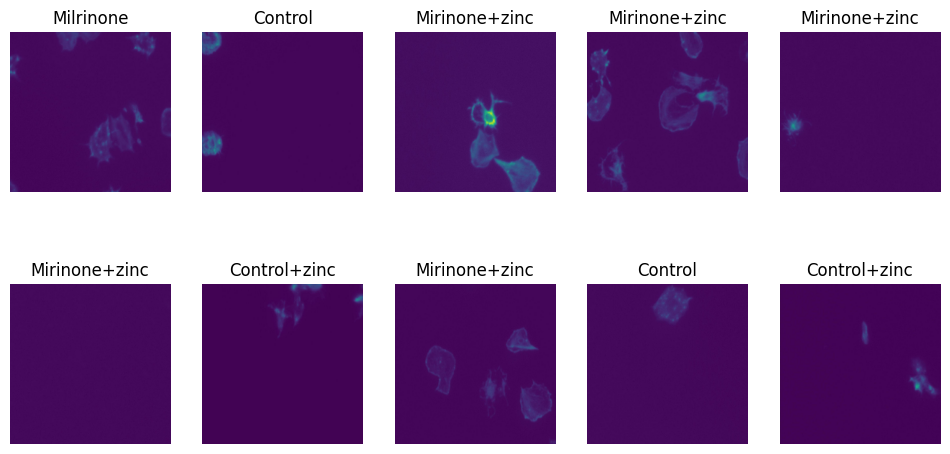

MCELLSs_CNN


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56

,accuracy,val_accuracy,loss,val_loss
0,0.314286,0.435,1.594910,1.219621
1,0.511429,0.525,1.107653,1.041976
2,0.645714,0.630,0.852485,0.925732
3,0.715714,0.465,0.696626,1.274415
4,0.758571,0.500,0.579787,1.661476
5,0.834286,0.580,0.432432,1.580641
6,0.888571,0.600,0.305243,1.544817
7,0.925714,0.570,0.227350,2.113534
8,0.924286,0.400,0.211593,3.417717
9,0.885714,0.455,0.371693,2.127997


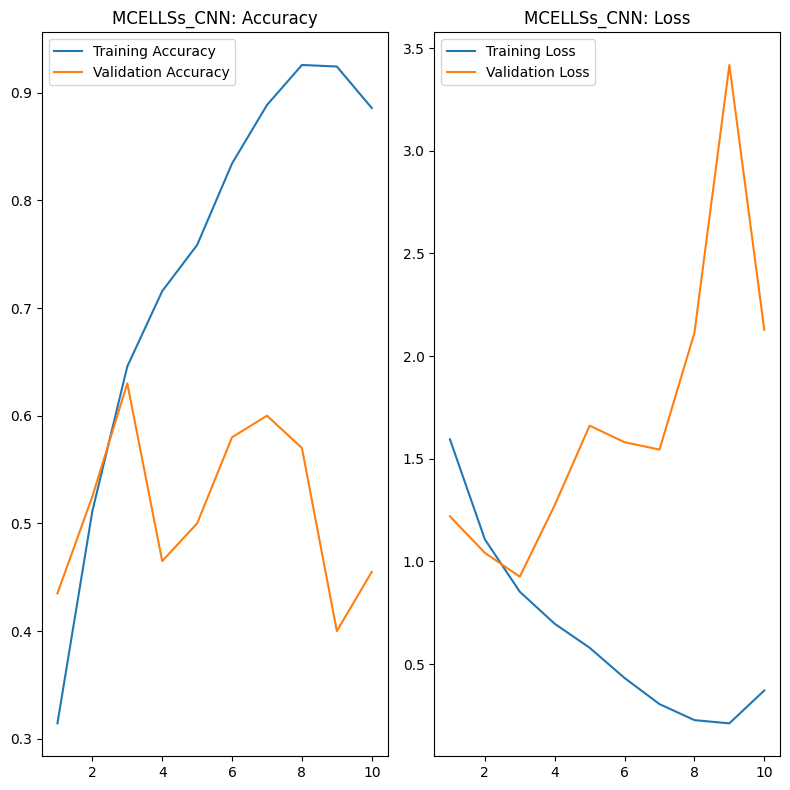

Plot Complete
7/7 [==============================] - 0s 13ms/step
Accuracy: 0.45
Precision: 0.4594891640866873
Recall: 0.45


               precision    recall  f1-score   support

      Control       0.47      0.32      0.38        25
 Control+zinc       0.60      0.48      0.53        25
    Milrinone       0.45      0.68      0.54        25
Mirinone+zinc       0.32      0.32      0.32        25

     accuracy                           0.45       100
    macro avg       0.46      0.45      0.44       100
 weighted avg       0.46      0.45      0.44       100

Confusion Matrix :


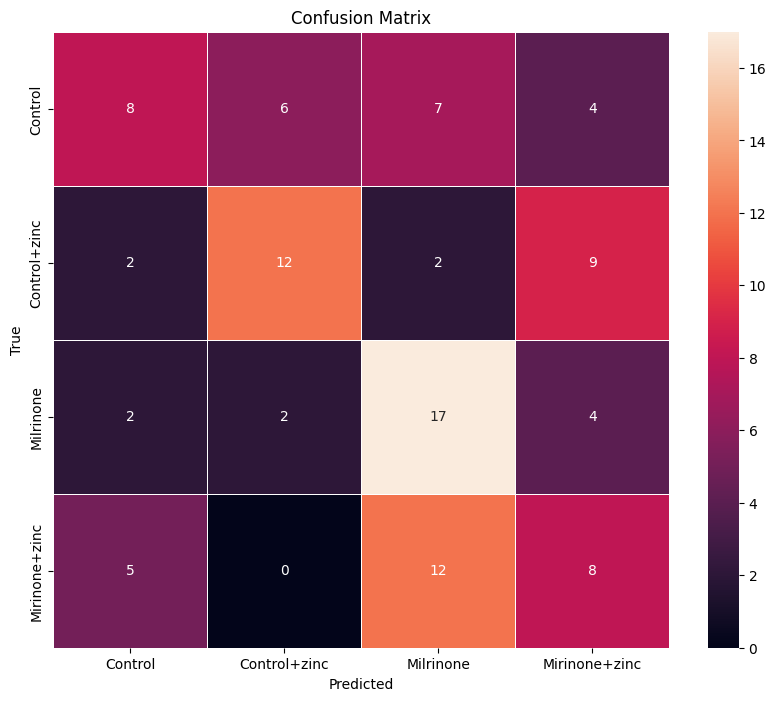

Evaluation Complete
-------------------------------------------------------------------------------------------------------------------------------


MCELLSs_CNN_BN


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)   

44/44 [==============================] - ETA: 0s - loss: 0.8962 - accuracy: 0.5914
Epoch 18: val_accuracy did not improve from 0.51000
44/44 [==============================] - 1s 22ms/step - loss: 0.8962 - accuracy: 0.5914 - val_loss: 9.9099 - val_accuracy: 0.3850
Epoch 19/50
43/44 [============================>.] - ETA: 0s - loss: 0.8605 - accuracy: 0.6206
Epoch 19: val_accuracy did not improve from 0.51000
44/44 [==============================] - 1s 22ms/step - loss: 0.8590 - accuracy: 0.6200 - val_loss: 18.7309 - val_accuracy: 0.2850
Epoch 20/50
43/44 [============================>.] - ETA: 0s - loss: 0.8639 - accuracy: 0.6177
Epoch 20: val_accuracy did not improve from 0.51000
44/44 [==============================] - 1s 22ms/step - loss: 0.8586 - accuracy: 0.6200 - val_loss: 1.2355 - val_accuracy: 0.4650
Epoch 21/50
43/44 [============================>.] - ETA: 0s - loss: 0.8516 - accuracy: 0.6206
Epoch 21: val_accuracy did not improve from 0.51000
44/44 [==========================

Epoch 47/50
43/44 [============================>.] - ETA: 0s - loss: 0.7065 - accuracy: 0.6788
Epoch 47: val_accuracy did not improve from 0.56000
44/44 [==============================] - 1s 22ms/step - loss: 0.7032 - accuracy: 0.6800 - val_loss: 2.6668 - val_accuracy: 0.3700
Epoch 48/50
43/44 [============================>.] - ETA: 0s - loss: 0.6709 - accuracy: 0.6933
Epoch 48: val_accuracy did not improve from 0.56000
44/44 [==============================] - 1s 22ms/step - loss: 0.6682 - accuracy: 0.6943 - val_loss: 3.6520 - val_accuracy: 0.4300
Epoch 49/50
43/44 [============================>.] - ETA: 0s - loss: 0.6815 - accuracy: 0.6890
Epoch 49: val_accuracy did not improve from 0.56000
44/44 [==============================] - 1s 22ms/step - loss: 0.6818 - accuracy: 0.6886 - val_loss: 1.7541 - val_accuracy: 0.4750
Epoch 50/50
43/44 [============================>.] - ETA: 0s - loss: 0.6994 - accuracy: 0.6890
Epoch 50: val_accuracy did not improve from 0.56000
44/44 [===============

,accuracy,val_accuracy,loss,val_loss
0,0.400000,0.250,3.368016,3.838715
1,0.407143,0.250,1.264500,4.871801
2,0.402857,0.250,1.204930,3.971151
3,0.398571,0.230,1.174472,3.275847
4,0.408571,0.155,1.175738,2.410476
5,0.385714,0.235,1.226307,1.567262
6,0.400000,0.285,1.243603,1.682499
7,0.414286,0.350,1.159556,1.496671
8,0.464286,0.415,1.210192,1.436651
9,0.507143,0.445,1.085498,1.513938


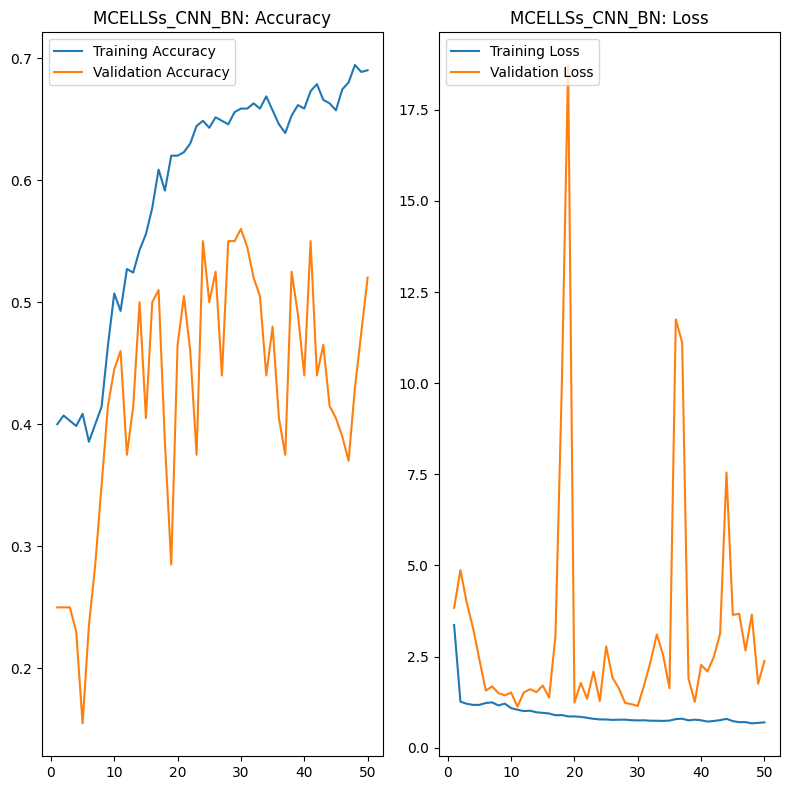

Plot Complete
7/7 [==============================] - 0s 5ms/step
Accuracy: 0.46
Precision: 0.5722506393861893
Recall: 0.46


               precision    recall  f1-score   support

      Control       0.44      0.60      0.51        25
 Control+zinc       0.70      0.28      0.40        25
    Milrinone       0.35      0.64      0.45        25
Mirinone+zinc       0.80      0.32      0.46        25

     accuracy                           0.46       100
    macro avg       0.57      0.46      0.45       100
 weighted avg       0.57      0.46      0.45       100

Confusion Matrix :


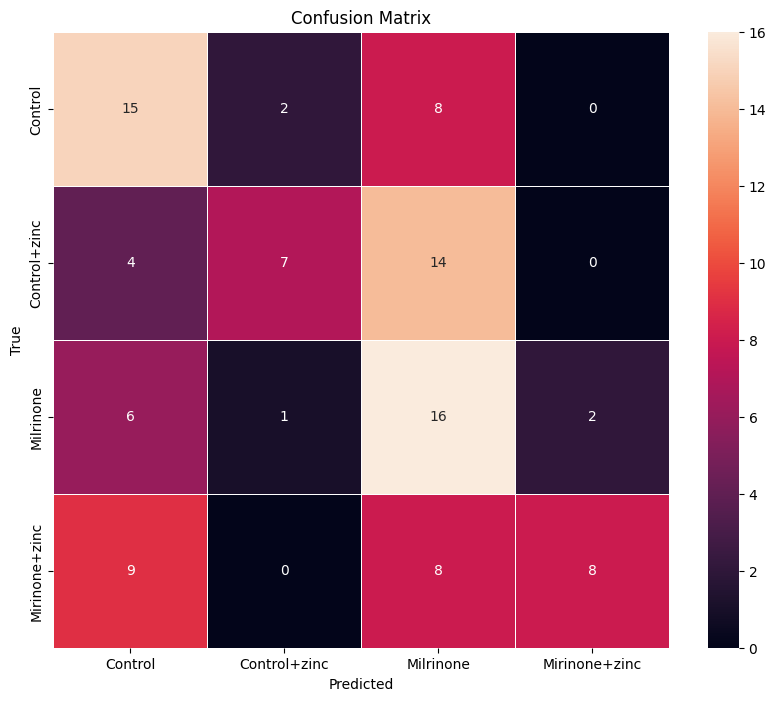

Evaluation Complete
-------------------------------------------------------------------------------------------------------------------------------


MCELLSs_CNN_DP


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                 

,accuracy,val_accuracy,loss,val_loss
0,0.245714,0.255,1.899351,1.383906
1,0.248571,0.250,1.386391,1.386310
2,0.250000,0.250,1.386402,1.386308
3,0.250000,0.250,1.386402,1.386306
4,0.250000,0.250,1.386402,1.386304
5,0.250000,0.250,1.386402,1.386303
6,0.250000,0.250,1.386402,1.386302
7,0.250000,0.250,1.386402,1.386301
8,0.250000,0.250,1.386402,1.386300
9,0.250000,0.250,1.386402,1.386299


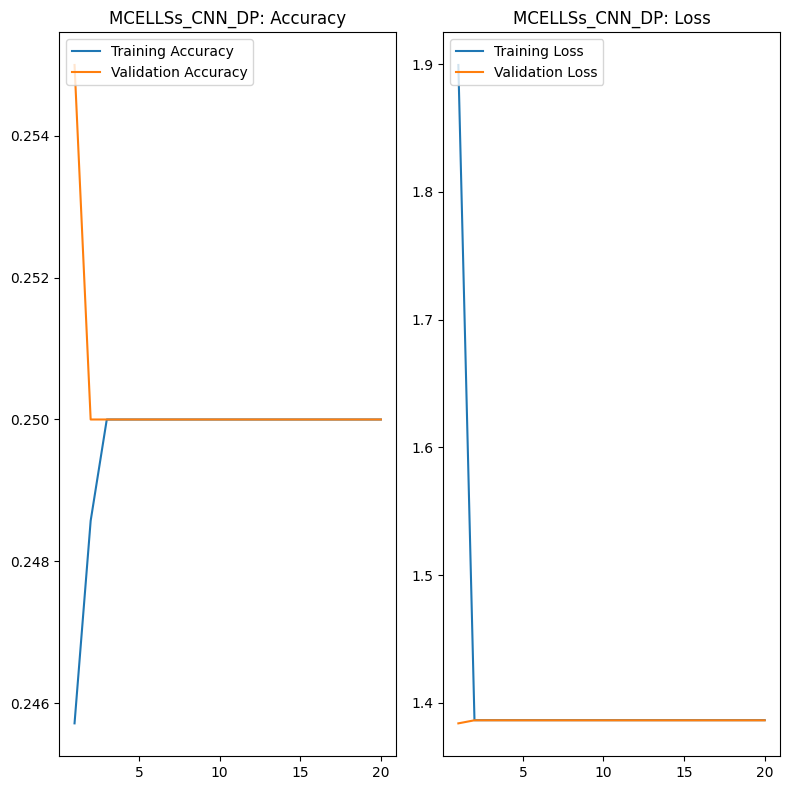

Plot Complete
7/7 [==============================] - 0s 6ms/step
Accuracy: 0.25
Precision: 0.0625
Recall: 0.25


               precision    recall  f1-score   support

      Control       0.00      0.00      0.00        25
 Control+zinc       0.25      1.00      0.40        25
    Milrinone       0.00      0.00      0.00        25
Mirinone+zinc       0.00      0.00      0.00        25

     accuracy                           0.25       100
    macro avg       0.06      0.25      0.10       100
 weighted avg       0.06      0.25      0.10       100

Confusion Matrix :


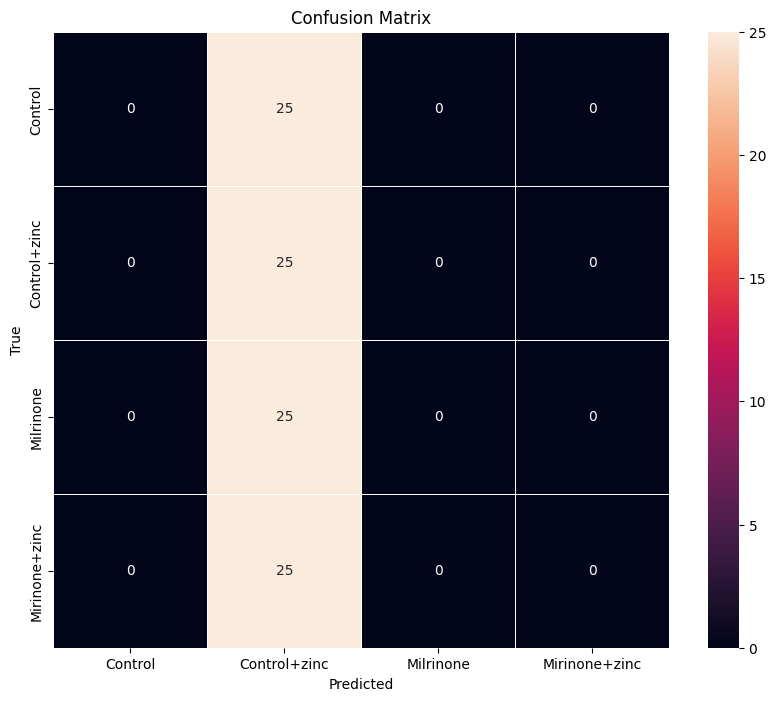

Evaluation Complete
-------------------------------------------------------------------------------------------------------------------------------


MCELLSs_CNN_LR


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                 

Epoch 20/20
43/44 [============================>.] - ETA: 0s - loss: 0.4977 - accuracy: 0.8140
Epoch 20: val_accuracy did not improve from 0.55000
44/44 [==============================] - 1s 14ms/step - loss: 0.4979 - accuracy: 0.8114 - val_loss: 1.5353 - val_accuracy: 0.4850
history saved


,accuracy,val_accuracy,loss,val_loss
0,0.255714,0.235,1.424607,1.379930
1,0.244286,0.240,1.359990,1.379296
2,0.258571,0.250,1.346574,1.355147
3,0.261429,0.255,1.314935,1.330345
4,0.284286,0.255,1.290896,1.309544
5,0.350000,0.275,1.264143,1.282798
6,0.400000,0.305,1.228421,1.259766
7,0.464286,0.455,1.200094,1.219971
8,0.514286,0.510,1.147415,1.194851
9,0.548571,0.540,1.092295,1.176839


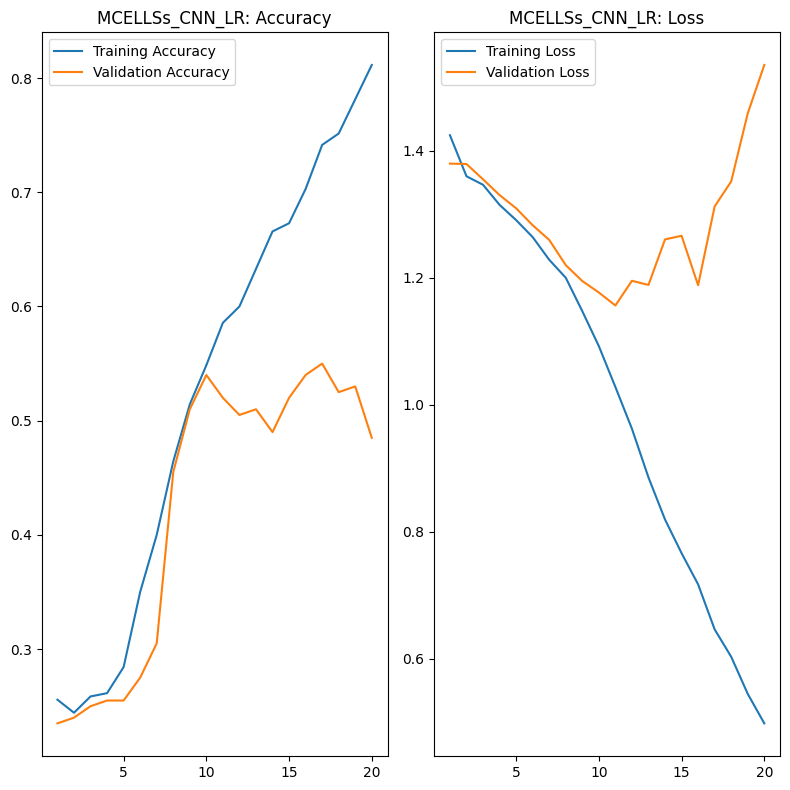

Plot Complete
7/7 [==============================] - 0s 4ms/step
Accuracy: 0.5
Precision: 0.5270684970014993
Recall: 0.5


               precision    recall  f1-score   support

      Control       0.43      0.40      0.42        25
 Control+zinc       0.75      0.48      0.59        25
    Milrinone       0.52      0.60      0.56        25
Mirinone+zinc       0.41      0.52      0.46        25

     accuracy                           0.50       100
    macro avg       0.53      0.50      0.50       100
 weighted avg       0.53      0.50      0.50       100

Confusion Matrix :


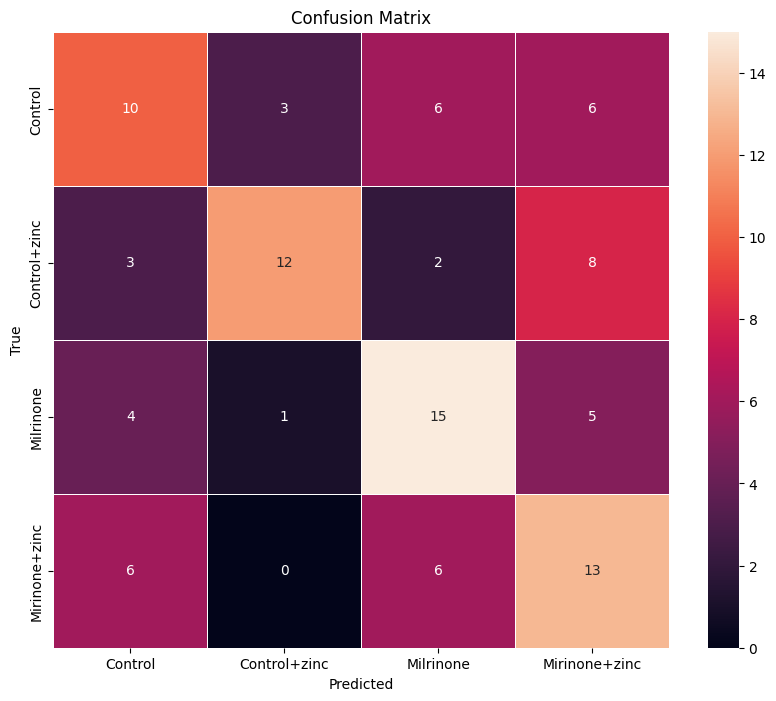

Evaluation Complete
-------------------------------------------------------------------------------------------------------------------------------


MCELLSs_CNN_BNDPLR


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D

43/44 [============================>.] - ETA: 0s - loss: 0.5824 - accuracy: 0.7137
Epoch 18: val_accuracy did not improve from 0.63000
44/44 [==============================] - 1s 22ms/step - loss: 0.5802 - accuracy: 0.7129 - val_loss: 0.9929 - val_accuracy: 0.6300
Epoch 19/20
43/44 [============================>.] - ETA: 0s - loss: 0.5711 - accuracy: 0.7297
Epoch 19: val_accuracy did not improve from 0.63000
44/44 [==============================] - 1s 22ms/step - loss: 0.5745 - accuracy: 0.7257 - val_loss: 1.0478 - val_accuracy: 0.6200
Epoch 20/20
43/44 [============================>.] - ETA: 0s - loss: 0.5983 - accuracy: 0.6933
Epoch 20: val_accuracy did not improve from 0.63000
44/44 [==============================] - 1s 22ms/step - loss: 0.5948 - accuracy: 0.6971 - val_loss: 1.0322 - val_accuracy: 0.6300
history saved


,accuracy,val_accuracy,loss,val_loss
0,0.401429,0.250,1.552072,2.945969
1,0.462857,0.250,1.132948,3.272356
2,0.455714,0.250,1.088886,3.453249
3,0.548571,0.250,0.949865,2.523827
4,0.555714,0.250,0.941217,2.371669
5,0.578571,0.380,0.901505,1.413944
6,0.580000,0.335,0.874341,1.307557
7,0.591429,0.415,0.806079,1.218826
8,0.617143,0.415,0.760071,1.151844
9,0.638571,0.480,0.717360,1.115771


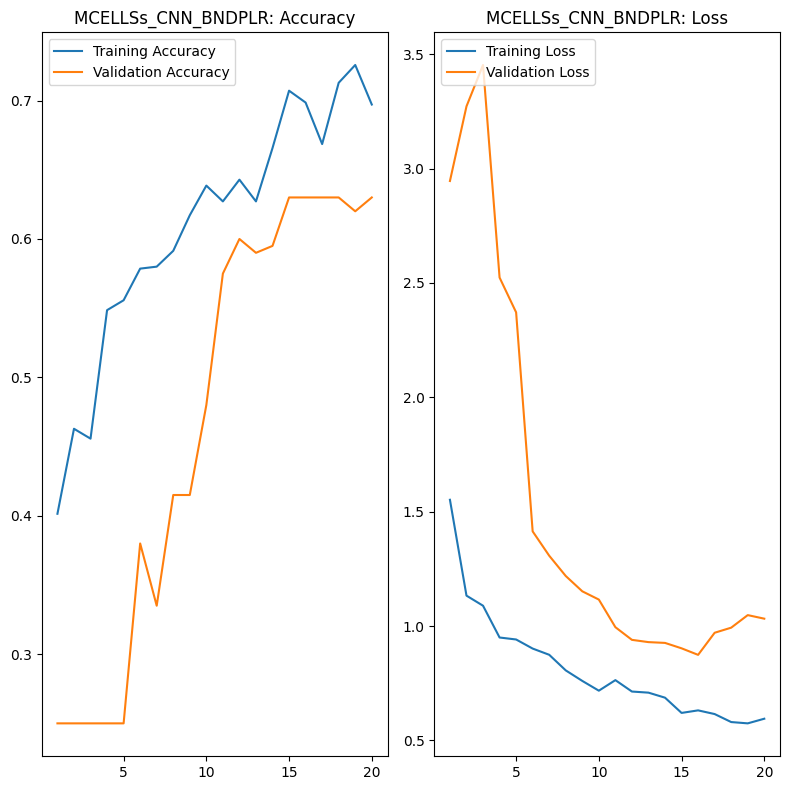

Plot Complete
7/7 [==============================] - 0s 6ms/step
Accuracy: 0.55
Precision: 0.5722862263184844
Recall: 0.55


               precision    recall  f1-score   support

      Control       0.40      0.48      0.44        25
 Control+zinc       0.76      0.64      0.70        25
    Milrinone       0.52      0.64      0.57        25
Mirinone+zinc       0.61      0.44      0.51        25

     accuracy                           0.55       100
    macro avg       0.57      0.55      0.55       100
 weighted avg       0.57      0.55      0.55       100

Confusion Matrix :


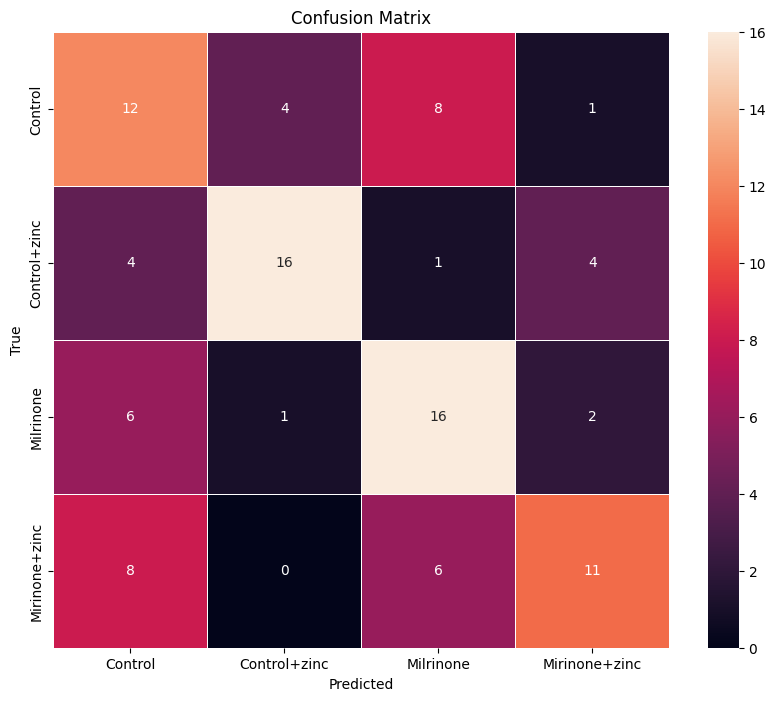

Evaluation Complete
-------------------------------------------------------------------------------------------------------------------------------


VGG16 for MCELLSs
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)   

44/44 [==============================] - ETA: 0s - loss: 1.2341 - accuracy: 0.3500
Epoch 18: val_accuracy did not improve from 0.29000
44/44 [==============================] - 3s 61ms/step - loss: 1.2341 - accuracy: 0.3500 - val_loss: 1.3990 - val_accuracy: 0.2900
Epoch 19/20
43/44 [============================>.] - ETA: 0s - loss: 1.2309 - accuracy: 0.3503
Epoch 19: val_accuracy improved from 0.29000 to 0.29500, saving model to C:\Users\conso\Desktop\pk\\chkps\MCELLSs_VGG16_chkp19-0.29.hdf5
44/44 [==============================] - 3s 64ms/step - loss: 1.2337 - accuracy: 0.3500 - val_loss: 1.3974 - val_accuracy: 0.2950
Epoch 20/20
43/44 [============================>.] - ETA: 0s - loss: 1.2305 - accuracy: 0.3503
Epoch 20: val_accuracy did not improve from 0.29500
44/44 [==============================] - 3s 61ms/step - loss: 1.2333 - accuracy: 0.3500 - val_loss: 1.4032 - val_accuracy: 0.2950
history saved


,accuracy,val_accuracy,loss,val_loss
0,0.264286,0.255,2.321610,1.383624
1,0.262857,0.255,1.397242,1.381607
2,0.280000,0.270,1.347243,1.377833
3,0.292857,0.250,1.344893,1.380915
4,0.297143,0.280,1.332601,1.395467
5,0.318571,0.255,1.334247,1.386257
6,0.300000,0.250,1.321596,1.385103
7,0.311429,0.265,1.309935,1.499032
8,0.331429,0.265,1.311994,1.394892
9,0.324286,0.270,1.268577,1.383226


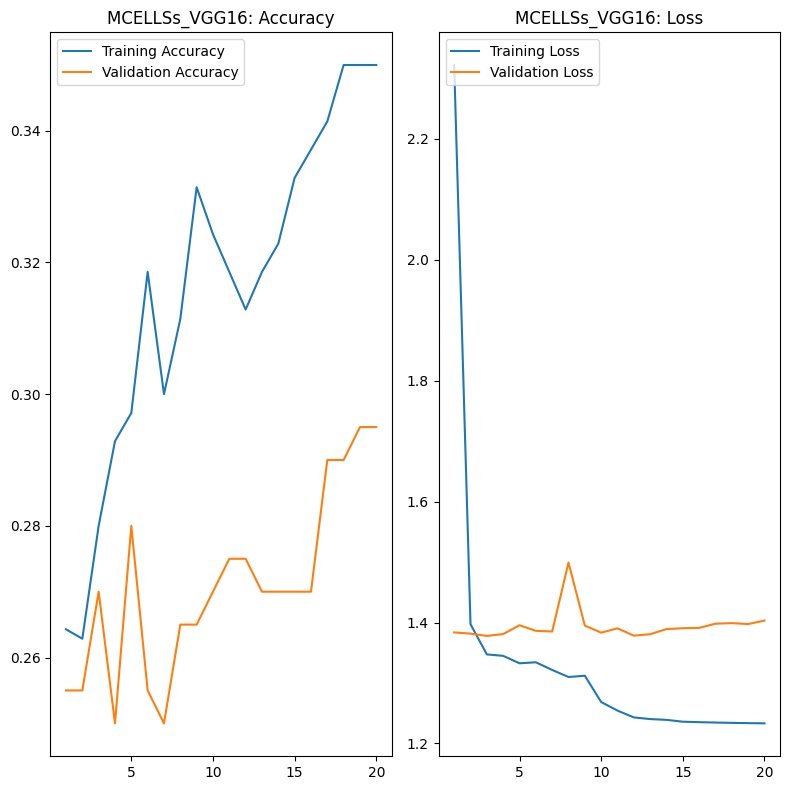

Plot Complete
7/7 [==============================] - 1s 190ms/step
Accuracy: 0.28
Precision: 0.27553763440860213
Recall: 0.28


               precision    recall  f1-score   support

      Control       0.50      0.08      0.14        25
 Control+zinc       0.27      1.00      0.42        25
    Milrinone       0.33      0.04      0.07        25
Mirinone+zinc       0.00      0.00      0.00        25

     accuracy                           0.28       100
    macro avg       0.28      0.28      0.16       100
 weighted avg       0.28      0.28      0.16       100

Confusion Matrix :


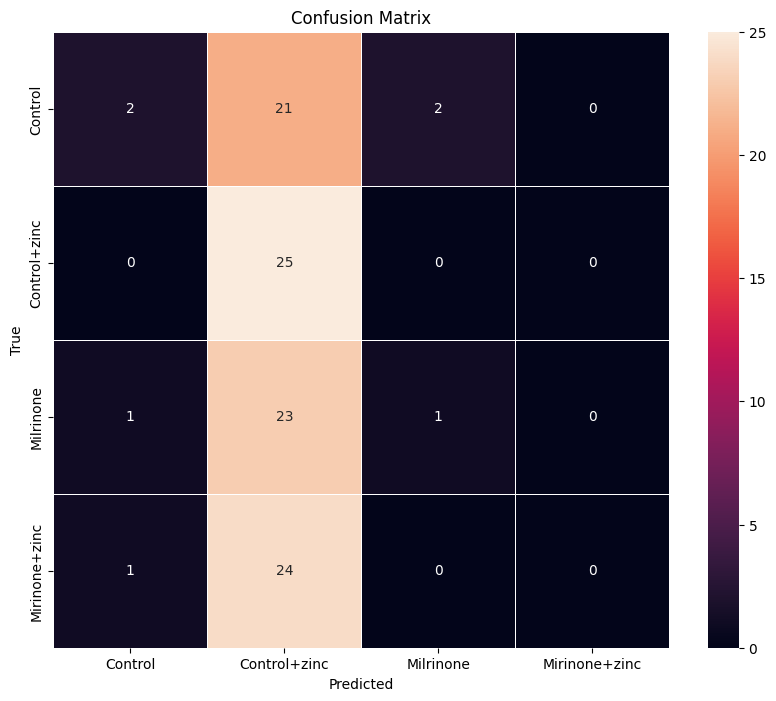

Evaluation Complete
VGG16 for MCELLSs COMPLETE
-------------------------------------------------------------------------------------------------------------------------------


VGG19 for MCELLSs
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                

Epoch 17/20
44/44 [==============================] - ETA: 0s - loss: 0.0265 - accuracy: 0.9943
Epoch 17: val_accuracy did not improve from 0.65000
44/44 [==============================] - 3s 72ms/step - loss: 0.0265 - accuracy: 0.9943 - val_loss: 1.9189 - val_accuracy: 0.6400
Epoch 18/20
43/44 [============================>.] - ETA: 0s - loss: 0.0224 - accuracy: 0.9942
Epoch 18: val_accuracy did not improve from 0.65000
44/44 [==============================] - 3s 71ms/step - loss: 0.0220 - accuracy: 0.9943 - val_loss: 1.9455 - val_accuracy: 0.6250
Epoch 19/20
43/44 [============================>.] - ETA: 0s - loss: 0.0201 - accuracy: 0.9942
Epoch 19: val_accuracy did not improve from 0.65000
44/44 [==============================] - 3s 72ms/step - loss: 0.0198 - accuracy: 0.9943 - val_loss: 2.0457 - val_accuracy: 0.6200
Epoch 20/20
44/44 [==============================] - ETA: 0s - loss: 0.0186 - accuracy: 0.9957
Epoch 20: val_accuracy did not improve from 0.65000
44/44 [===============

,accuracy,val_accuracy,loss,val_loss
0,0.430000,0.595,2.255291,1.081607
1,0.680000,0.515,0.762613,1.236167
2,0.774286,0.615,0.570126,1.066552
3,0.837143,0.620,0.423732,0.958067
4,0.875714,0.650,0.301025,0.978659
5,0.910000,0.610,0.239557,1.304803
6,0.935714,0.645,0.184649,1.320216
7,0.952857,0.635,0.135622,1.438424
8,0.964286,0.635,0.109419,1.498257
9,0.948571,0.610,0.148581,1.646205


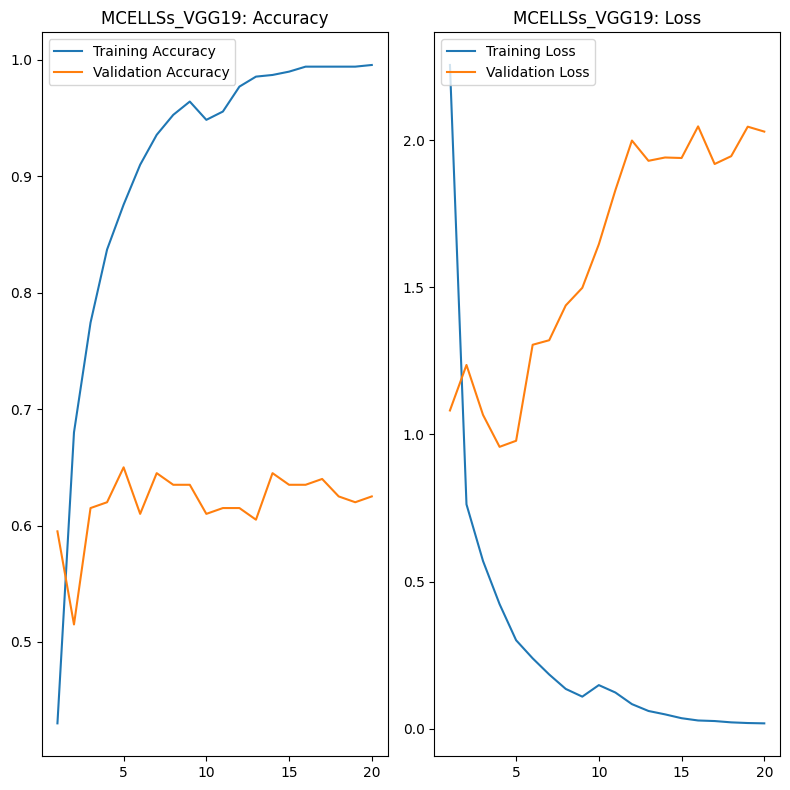

Plot Complete
7/7 [==============================] - 0s 55ms/step
Accuracy: 0.65
Precision: 0.6705738705738706
Recall: 0.65


               precision    recall  f1-score   support

      Control       0.72      0.52      0.60        25
 Control+zinc       0.81      0.84      0.82        25
    Milrinone       0.67      0.56      0.61        25
Mirinone+zinc       0.49      0.68      0.57        25

     accuracy                           0.65       100
    macro avg       0.67      0.65      0.65       100
 weighted avg       0.67      0.65      0.65       100

Confusion Matrix :


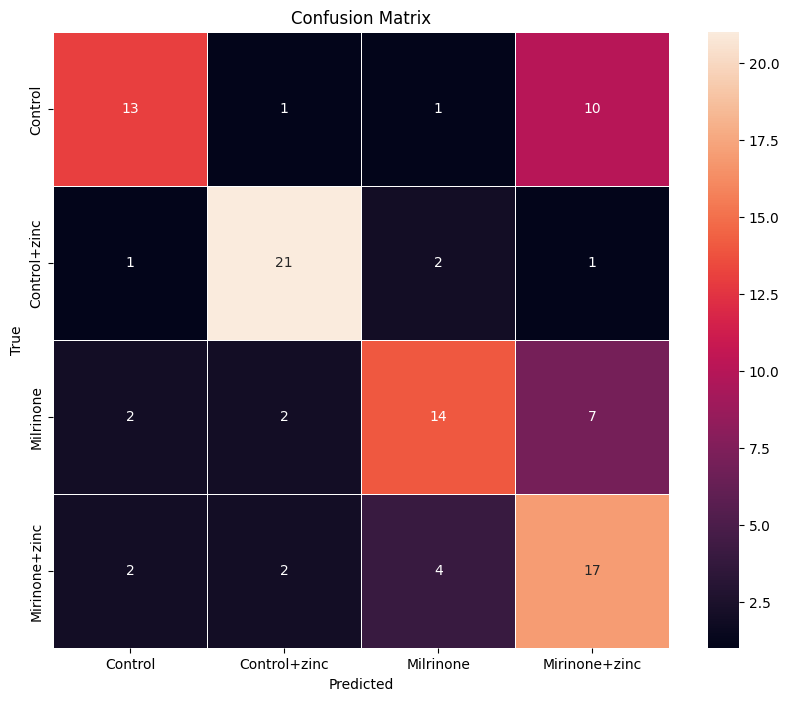

Evaluation Complete
VGG19 for MCELLSs COMPLETE
-------------------------------------------------------------------------------------------------------------------------------


Whole Process Complete for MCELLSs




In [20]:
# The directory where the classes are is MCells.
directory = r'C:\Users\conso\Desktop\pk\MCELLSs'

# dir_x is the directory that helps in saving of my checkpoints and callbacks
dir_x = directory[:26] # C:\Users\conso\Desktop\kk\ - this is useful for model checkpoints and full filepath.

# name is the name of the current model which is MCells and it is used in naming tables and graphs etc
name = directory[26:] # MCells

# call the function run_whole_process
name, train_ds, val_ds, test_ds, class_names, num_class, results = run_whole_process(directory, name, num_of_aug_per_image = 4, 
                                                                                    nos_of_classes = 4, 
                                                                                    aug = False, 
                                                                                    test = True)

In [21]:
xxxx

NameError: name 'xxxx' is not defined

#### Randomized search

In [ ]:
# call the Randomized search function
results = randomize_search(name, train_ds, val_ds,test_ds, class_names, num_class, results, test = True)

### Bayesian search

In [ ]:
# call the Bayesian search search function
results = bayes_opt_search(name, train_ds, val_ds, test_ds, class_names, num_class, results)

### SORT THE RESULT AND SHOW THE DATAFRAME

In [ ]:
results_sorted = sorted(results, key= lambda x:x['Accuracy'] , reverse=True)
df = pd.DataFrame(results_sorted)
df

In [ ]:
df.to_csv('Multi_class_without_augmentation.csv', index=False)

### ENSEMBLE LEARNING

https://www.youtube.com/watch?v=-ix_Mjzu8BU&t=198s

---
    Selecting the 5 model checkpoints that have high val_accuracy but not deemed to overfit
    
---

In [ ]:
name_model1 = r'C:\Users\conso\Desktop\tk\\chkps\MCells_CNN_BNDPLR_chkpt_16-0.62.hdf5'
name_model2 = r'C:\Users\conso\Desktop\tk\\chkps\MCells_VGG19_chkp_05-0.65.hdf5'
name_model3 = r'C:\Users\conso\Desktop\tk\\chkps\MCells_VGG19_chkp_05-0.65.hdf5'
name_model4 = r'C:\Users\conso\Desktop\tk\\chkps\MCells_CNN_BNDPLR_chkpt_14-0.62.hdf5'
name_model5 = r'C:\Users\conso\Desktop\tk\\chkps\MCells_CNN_LR_chkpt_10-0.54.hdf5'

model1 = load_model(name_model1)
model2 = load_model(name_model2)
model3 = load_model(name_model3)
model4 = load_model(name_model4)
model5 = load_model(name_model5)


models = [model1, model2, model3, model4, model5]
name_models = [name_model1[33:-5], name_model2[33:-5], name_model3[33:-5], name_model4[33:-5], name_model5[33:-5]]

# EVALAUTE THE SELECTED MODELS

- https://www.youtube.com/watch?v=-ix_Mjzu8BU&t=616s

In [ ]:
test_labels = np.concatenate([y for _, y in test_ds], axis=0)
t_label = np.argmax(test_labels, axis=1)


predictions = []
accuracies = []
precisions = []
recalls = []

for model in models:
    prediction = model.predict(test_ds)
    pred = np.argmax(prediction, axis=1)
    accuracy = accuracy_score(t_label, pred)
    precision = precision_score(t_label, pred,average='weighted')
    recall = recall_score(t_label, pred, average='weighted')
    predictions.append(prediction)
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)

preds= np.array(predictions)
summed = np.sum(preds, axis=0)
# argmax across classes
ensemble_prediction = np.argmax(summed, axis=1)
# get the ensemble accuracy score
ensemble_accuracy = accuracy_score(t_label, ensemble_prediction)
ensemble_precision = precision_score(t_label, ensemble_prediction,average='weighted')
ensemble_recall = recall_score(t_label, ensemble_prediction, average='weighted')

# Print the accuracy scores
selected_results = []
for model,accuracy, precision, recall in zip(name_models, accuracies, precisions, recalls):
    selected_results.append({'Model' : model , 'Accuracy': accuracy, 'Precison': precision,'Recall': recall})

selected_results.append({'Model':'Ensemble Model','Accuracy':ensemble_accuracy,'Precison':ensemble_precision,'Recall': ensemble_recall})

In [ ]:
results_sorted = sorted(selected_results, key= lambda x:x['Accuracy'] , reverse=True)
df = pd.DataFrame(results_sorted)
df

In [ ]:
df.to_csv('Multi_class_ensemble_without_augmentation.csv', index=False)

## YOLOv8

- https://www.youtube.com/watch?v=ZeLg5rxLGLg&t=1885s
- https://github.com/computervisioneng/image-classification-yolov8

In [ ]:
from operator import truediv
import numpy as np
from ultralytics import YOLO

In [ ]:
from keras import backend as K
K.clear_session()

In [ ]:
model = YOLO('yolov8n-cls.pt')  # load a pretrained model (recommended for training)

model.train(data=r'C:\Users\conso\Desktop\tk\MCells\Completed_2',
            epochs=30, imgsz=64)

In [ ]:
results_path = r"C:\Users\conso\Desktop\ok\runs\classify\train13\results.csv"


results = pd.read_csv(results_path)

plt.figure()
plt.plot(results['                  epoch'], results['             train/loss'], label='train loss')
plt.plot(results['                  epoch'], results['               val/loss'], label='val loss', c='red')
plt.grid()
plt.title('Loss vs epochs')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()


plt.figure()
plt.plot(results['                  epoch'], results['  metrics/accuracy_top1'] * 100)
plt.grid()
plt.title('Validation accuracy vs epochs')
plt.ylabel('accuracy (%)')
plt.xlabel('epochs')

plt.show()

In [ ]:
results.columns

In [ ]:
final_results = results[['                  epoch', '             train/loss','               val/loss',
       '  metrics/accuracy_top1']]
final_results

In [ ]:
model = YOLO(r"C:\Users\conso\Desktop\ok\runs\classify\train13\weights\best.pt")  # load a custom model

results = model(r"C:\Users\conso\Desktop\kk\MCells\Completed_2\test\Control\Fib 100 Control 19.01.21-03_1_1.jpg")  # predict on an image

names_dict = results[0].names

probs = results[0].probs.data.tolist()

print(names_dict)
print(probs)

print(names_dict[np.argmax(probs)])

In [ ]:
#model = YOLO(r"C:\Users\conso\runs\classify\train7\weights\last.pt")  # load a custom model

results = model(r"C:\Users\conso\Desktop\kk\MCells\Completed_2\test\Mirinone+zinc\Fib 100 zinc+Milrinone 25.05.22 D004_4_1.jpg")  # predict on an image

names_dict = results[0].names

probs = results[0].probs.data.tolist()

print(names_dict)
print(probs)

print(names_dict[np.argmax(probs)])

### get confusion matrix

In [ ]:
#Open the images
image = Image.open(r"C:\Users\conso\Desktop\ok\runs\classify\train13\confusion_matrix.png")

plt.figure(figsize=(16, 16))
plt.imshow(image)
plt.axis('off')
plt.show()

## Calculate recall and precision from confusion matrix

In [ ]:
# https://stackoverflow.com/questions/40729875/calculate-precision-and-recall-in-a-confusion-matrix
conf_matrix = [
    [35, 0, 4, 5],
    [3, 48, 0, 2],
    [6, 1, 40, 5],
    [6, 1, 6, 38]
]

tp = np.diag(conf_matrix)
precision = list(map(truediv, tp, np.sum(conf_matrix, axis=0)))
recall = list(map(truediv, tp, np.sum(conf_matrix, axis=1)))
print('Recall :', np.mean(recall))
print('Precision :',np.mean(precision))

# Read in the csv file saved earlier

In [ ]:
df = pd.read_csv(r"C:\Users\conso\Desktop\ok\Multi_class_without_augmentation.csv")

# Add the Yolov8 results

In [ ]:
#https://stackoverflow.com/questions/37897527/get-python-pandas-to-dict-with-orient-records-but-without-float-cast

results = df.to_dict(orient='records')

data = {'Model': 'Yolov8', 'Accuracy': 0.81, 'Precison': 0.80, 'Recall': 0.80}

results.append(data)

In [ ]:
results

# Sort the results

In [ ]:
results_sorted = sorted(results, key= lambda x:x['Accuracy'] , reverse=True)
df = pd.DataFrame(results_sorted)
df

# Save the results

In [ ]:
df.to_csv('Multi_class_Yolov8_without_augmentation.csv', index=False)

# REPEAT THE ABOVE STEPS FOR EVERY OTHER CLASSIFICATIONS

### MULTI CELLS CLASSIFICATION WITH AUGMENTATION

In [ ]:
directory = r'C:\Users\conso\Desktop\kk\MCELLS_aug'
dir_x = directory[:26]
name = directory[26:]
name, train_ds, val_ds, test_ds, class_names, num_class, results = run_whole_process(directory, name, num_of_aug_per_image = 4, 
                                                                                    nos_of_classes = 4, 
                                                                                    aug = True, 
                                                                                    test = True)

#### Randomized search

In [ ]:
# Randomized search
results = randomize_search(name, train_ds, val_ds,test_ds, class_names, num_class, results, test = True)

### Bayesian search

In [ ]:
# Bayesian search
results = bayes_opt_search(name, train_ds, val_ds, test_ds, class_names, num_class, results)

In [ ]:
results_sorted = sorted(results, key= lambda x:x['Accuracy'] , reverse=True)
df = pd.DataFrame(results_sorted)
df

### ENSEMBLE LEARNING

https://www.youtube.com/watch?v=-ix_Mjzu8BU&t=198s

In [ ]:
name_model1 = r'C:\Users\conso\Desktop\kk\\chkps\MCELLS_aug_top3_r_checkpoints_20-0.69.hdf5'
name_model2 = r'C:\Users\conso\Desktop\kk\\chkps\MCELLS_aug_top3_b_checkpoints_13-0.67.hdf5'
name_model3 = r'C:\Users\conso\Desktop\kk\\chkps\MCELLS_aug_top1_r_checkpoints_12-0.64.hdf5'
name_model4 = r'C:\Users\conso\Desktop\kk\\chkps\MCELLS_aug_VGG19_chkp_06-0.55.hdf5'
name_model5 = r'C:\Users\conso\Desktop\kk\\chkps\MCELLS_aug_VGG16_chkp09-0.67.hdf5'

model1 = load_model(name_model1)
model2 = load_model(name_model2)
model3 = load_model(name_model3)
model4 = load_model(name_model4)
model5 = load_model(name_model5)


models = [model1, model2, model3, model4, model5]
name_models = [name_model1[33:-5], name_model2[33:-5], name_model3[33:-5], name_model4[33:-5], name_model5[33:-5]]

In [ ]:
test_labels = np.concatenate([y for _, y in test_ds], axis=0)
t_label = np.argmax(test_labels, axis=1)


predictions = []
accuracies = []
precisions = []
recalls = []

for model in models:
    prediction = model.predict(test_ds)
    pred = np.argmax(prediction, axis=1)
    accuracy = accuracy_score(t_label, pred)
    precision = precision_score(t_label, pred,average='weighted')
    recall = recall_score(t_label, pred, average='weighted')
    predictions.append(prediction)
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)

preds= np.array(predictions)
summed = np.sum(preds, axis=0)

# argmax across classes
ensemble_prediction = np.argmax(summed, axis=1)
# get the ensemble accuracy score
ensemble_accuracy = accuracy_score(t_label, ensemble_prediction)
ensemble_precision = precision_score(t_label, ensemble_prediction,average='weighted')
ensemble_recall = recall_score(t_label, ensemble_prediction, average='weighted')

# APPEND ACCURACY SCORES IN LIST
selected_results = []
for model,accuracy, precision, recall in zip(name_models, accuracies, precisions, recalls):
    selected_results.append({'Model' : model , 'Accuracy': accuracy, 'Precison': precision,'Recall': recall})

# APPEND ENSEMBLE SCORE TO LIST
selected_results.append({'Model':'Ensemble Model','Accuracy':ensemble_accuracy,'Precison':ensemble_precision,'Recall': ensemble_recall})

In [ ]:
# SORT RESULTS ACCORDING TO ACCURACY FROM HIGHEST TO LOWEST
results_sorted = sorted(selected_results, key= lambda x:x['Accuracy'] , reverse=True)
df = pd.DataFrame(results_sorted)
df

In [ ]:
df.to_csv('Multi_class_with_augmentation.csv', index=False)

## YOLOv8

In [ ]:
from keras import backend as K
K.clear_session()

In [ ]:
model = YOLO('yolov8n-cls.pt')  # load a pretrained model (recommended for training)

model.train(data=r'C:\Users\conso\Desktop\kk\MCells_aug\Completed_2',
            epochs=30, imgsz=64)

In [ ]:
results_path = r"C:\Users\conso\Desktop\ok\runs\classify\train15\results.csv"


results = pd.read_csv(results_path)

plt.figure()
plt.plot(results['                  epoch'], results['             train/loss'], label='train loss')
plt.plot(results['                  epoch'], results['               val/loss'], label='val loss', c='red')
plt.grid()
plt.title('Loss vs epochs')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()


plt.figure()
plt.plot(results['                  epoch'], results['  metrics/accuracy_top1'] * 100)
plt.grid()
plt.title('Validation accuracy vs epochs')
plt.ylabel('accuracy (%)')
plt.xlabel('epochs')

plt.show()

In [ ]:
results.columns

In [ ]:
final_results = results[['                  epoch', '             train/loss','               val/loss',
       '  metrics/accuracy_top1']]
final_results

In [ ]:
model = YOLO(r"C:\Users\conso\Desktop\ok\runs\classify\train15\weights\best.pt")  # load a custom model

results = model(r"C:\Users\conso\Desktop\kk\MCELLS_aug\Completed_2\test\Control+zinc\Fib 100 Control + Zinc 23.03.22 D027-03_0_3.jpg")  # predict on an image

names_dict = results[0].names

probs = results[0].probs.data.tolist()

print(names_dict)
print(probs)

print(names_dict[np.argmax(probs)])

In [ ]:
#model = YOLO(r"C:\Users\conso\runs\classify\train7\weights\last.pt")  # load a custom model

results = model(r"C:\Users\conso\Desktop\kk\MCELLS_aug\Completed_2\test\Mirinone+zinc\Fib 100  Zinc+ 10uM Milrinone D031 05.04.22-02_1_3.jpg")  # predict on an image

names_dict = results[0].names

probs = results[0].probs.data.tolist()

print(names_dict)
print(probs)

print(names_dict[np.argmax(probs)])

### get confusion matrix

In [ ]:
#Open the images
image = Image.open(r"C:\Users\conso\Desktop\ok\runs\classify\train15\confusion_matrix.png")

plt.figure(figsize=(16, 16))
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
conf_matrix = [
    [35, 6, 6, 13],
    [5, 42, 6, 1],
    [2, 0, 25, 2],
    [8, 2, 13, 34]
]

tp = np.diag(conf_matrix)
precision = list(map(truediv, tp, np.sum(conf_matrix, axis=0)))
recall = list(map(truediv, tp, np.sum(conf_matrix, axis=1)))
print('Recall :', np.mean(recall))
print('Precision :',np.mean(precision))

In [ ]:
df = pd.read_csv(r"C:\Users\conso\Desktop\ok\Multi_class_with_augmentation.csv")

In [ ]:
#https://stackoverflow.com/questions/37897527/get-python-pandas-to-dict-with-orient-records-but-without-float-cast

results = df.to_dict(orient='records')

data = {'Model': 'Yolov8', 'Accuracy': 0.68, 'Precison': 0.68, 'Recall': 0.71}

results.append(data)

In [ ]:
results_sorted = sorted(results, key= lambda x:x['Accuracy'] , reverse=True)
df = pd.DataFrame(results_sorted)
df

## CONTROL VS OTHERS - WITHOUT AUGMENTATION

In [ ]:
directory = r'C:\Users\conso\Desktop\kk\CvO'
dir_x = directory[:26]
name = directory[26:]
name, train_ds, val_ds, test_ds, class_names, num_class, results = run_whole_process(directory, name, num_of_aug_per_image = 4, 
                                                                                    nos_of_classes = 2, 
                                                                                    aug = False, 
                                                                                    test = True)

In [ ]:
# Randomized search
results = randomize_search(name, train_ds, val_ds,test_ds, class_names, num_class, results, test = True)

In [ ]:
# Bayesian search
results = bayes_opt_search(name, train_ds, val_ds, test_ds, class_names, num_class, results)

In [ ]:
results_sorted = sorted(results, key= lambda x:x['Accuracy'] , reverse=True)
df = pd.DataFrame(results_sorted)
df

In [ ]:
df.to_csv('Control_vs_Others_without_augmentation.csv', index=False)

### ENSEMBLE LEARNING

https://www.youtube.com/watch?v=-ix_Mjzu8BU&t=198s

In [ ]:
name_model1 = r'C:\Users\conso\Desktop\kk\\chkps\CvO_top3_b_checkpoints_05-0.71.hdf5'
name_model2 = r'C:\Users\conso\Desktop\kk\\chkps\CvO_top2_r_checkpoints_07-0.70.hdf5'
name_model3 = r'C:\Users\conso\Desktop\kk\\chkps\CvO_VGG19_chkp_03-0.73.hdf5'
name_model4 = r'C:\Users\conso\Desktop\kk\\chkps\CvO_VGG16_chkp07-0.71.hdf5'
name_model5 = r'C:\Users\conso\Desktop\kk\\chkps\CvO_CNN_BNDPLR_chkpt_10-0.66.hdf5'

model1 = load_model(name_model1)
model2 = load_model(name_model2)
model3 = load_model(name_model3)
model4 = load_model(name_model4)
model5 = load_model(name_model5)

modelss = [model1, model2, model3, model4, model5]
name_models = [name_model1[33:-5], name_model2[33:-5], name_model3[33:-5], name_model4[33:-5], name_model5[33:-5]]

In [ ]:
predictions = []
accuracies = []
precisions = []
recalls = []

# Evaluate the model
labels = np.concatenate([y for _, y in test_ds], axis=0)
labels_binary = (labels > 0.5).astype(int)
for model in modelss:
    prediction = model.predict(test_ds)
    
    # Evaluate the model
    labels = np.concatenate([y for _, y in test_ds], axis=0)
    prediction = (prediction > 0.5).astype(int)
    
    # Convert validation labels to binary format
    labels_binary = (labels > 0.5).astype(int)

    # Get accuracy, precison and recall
    accuracy = accuracy_score(labels_binary, prediction)
    precision = precision_score(labels_binary, prediction)
    recall = recall_score(labels_binary, prediction)
    
    predictions.append(prediction)
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)

# argmax across classes
ensemble_prediction = np.sum(predictions, axis=0)
ensemble_prediction = (ensemble_prediction > len(models) / 2).astype(int)

# get the ensemble accuracy score
ensemble_accuracy = accuracy_score(labels_binary, ensemble_prediction)
ensemble_precision = precision_score(labels_binary, ensemble_prediction)
ensemble_recall = recall_score(labels_binary, ensemble_prediction)

# APPEND ACCURACY SCORES IN LIST
selected_results = []
for model,accuracy, precision, recall in zip(name_models, accuracies, precisions, recalls):
    selected_results.append({'Model' : model , 'Accuracy': accuracy, 'Precison': precision,'Recall': recall})

# APPEND ENSEMBLE SCORE TO LIST
selected_results.append({'Model':'Ensemble Model','Accuracy':ensemble_accuracy,'Precison':ensemble_precision,'Recall': ensemble_recall})

In [ ]:
# SORT RESULTS ACCORDING TO ACCURACY FROM HIGHEST TO LOWEST
results_sorted = sorted(selected_results, key= lambda x:x['Accuracy'] , reverse=True)
df = pd.DataFrame(results_sorted)
df

In [ ]:
df.to_csv('Control_vs_others_ensemble_without_augmentation.csv', index=False)

## YOLOv8

In [ ]:
from keras import backend as K
K.clear_session()
from operator import truediv
from ultralytics import YOLO

In [ ]:
model = YOLO('yolov8n-cls.pt')  # load a pretrained model (recommended for training)

model.train(data=r'C:\Users\conso\Desktop\kk\CvO\Completed_2',
            epochs=30, imgsz=64)

In [ ]:
results_path = r"C:\Users\conso\Desktop\ok\runs\classify\train16\results.csv"


results = pd.read_csv(results_path)

plt.figure()
plt.plot(results['                  epoch'], results['             train/loss'], label='train loss')
plt.plot(results['                  epoch'], results['               val/loss'], label='val loss', c='red')
plt.grid()
plt.title('Loss vs epochs')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()


plt.figure()
plt.plot(results['                  epoch'], results['  metrics/accuracy_top1'] * 100)
plt.grid()
plt.title('Validation accuracy vs epochs')
plt.ylabel('accuracy (%)')
plt.xlabel('epochs')

plt.show()

In [ ]:
results.columns

In [ ]:
final_results = results[['                  epoch', '             train/loss','               val/loss',
       '  metrics/accuracy_top1']]
final_results

In [ ]:
model = YOLO(r"C:\Users\conso\Desktop\ok\runs\classify\train16\weights\best.pt")  # load a custom model

results = model(r"C:\Users\conso\Desktop\kk\CvO\Completed_2\test\Control\Fib100 Control 20.01.22-04_1_1.jpg")
names_dict = results[0].names

probs = results[0].probs.data.tolist()

print(names_dict)
print(probs)

print(names_dict[np.argmax(probs)])

In [ ]:
#model = YOLO(r"C:\Users\conso\runs\classify\train7\weights\last.pt")  # load a custom model

results = model(r"C:\Users\conso\Desktop\kk\CvO\Completed_2\test\Other Cells\Fib 100  Zinc+ 10uM Milrinone D031 05.04.22-02_0_2.jpg")  # predict on an image

names_dict = results[0].names

probs = results[0].probs.data.tolist()

print(names_dict)
print(probs)

print(names_dict[np.argmax(probs)])

### get confusion matrix

In [ ]:
#Open the images
image = Image.open(r"C:\Users\conso\Desktop\ok\runs\classify\train16\confusion_matrix.png")

plt.figure(figsize=(16, 16))
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
conf_matrix = [
    [122, 31],
    [53, 144]
    ]

tp = np.diag(conf_matrix)
precision = list(map(truediv, tp, np.sum(conf_matrix, axis=0)))
recall = list(map(truediv, tp, np.sum(conf_matrix, axis=1)))
print('Recall :', np.mean(recall))
print('Precision :',np.mean(precision))

In [ ]:
df = pd.read_csv(r"C:\Users\conso\Desktop\ok\Control_vs_others_ensemble_without_augmentation.csv")

In [ ]:
#https://stackoverflow.com/questions/37897527/get-python-pandas-to-dict-with-orient-records-but-without-float-cast

results = df.to_dict(orient='records')

data = {'Model': 'Yolov8', 'Accuracy': 0.76, 'Precison': 0.76, 'Recall': 0.76}

results.append(data)

In [ ]:
results_sorted = sorted(results, key= lambda x:x['Accuracy'] , reverse=True)
df = pd.DataFrame(results_sorted)
df

In [ ]:
df.to_csv('Control_vs_others_ensemble_YOLO_without_augmentation.csv', index=False)

## CONTROL VS OTHERS - WITH AUGMENTATION

In [ ]:
directory = r'C:\Users\conso\Desktop\kk\CvO_aug'
dir_x = directory[:26]
name = directory[26:]
name, train_ds, val_ds, test_ds, class_names, num_class, results = run_whole_process(directory, name, num_of_aug_per_image = 4, 
                                                                                    nos_of_classes = 2, 
                                                                                    aug = True, 
                                                                                    test = True)

In [ ]:
# Randomized search
results = randomize_search(name, train_ds, val_ds,test_ds, class_names, num_class, results, test = True)

In [ ]:
# Bayesian search
results = bayes_opt_search(name, train_ds, val_ds, test_ds, class_names, num_class, results)

In [ ]:
results_sorted = sorted(results, key= lambda x:x['Accuracy'] , reverse=True)
df = pd.DataFrame(results_sorted)
df

In [ ]:
df.to_csv('Control_vs_Others_with_augmentation.csv', index=False)

### ENSEMBLE LEARNING

https://www.youtube.com/watch?v=-ix_Mjzu8BU&t=198s

In [ ]:
name_model1 = r'C:\Users\conso\Desktop\kk\\chkps\CvO_aug_top3_b_checkpoints_04-0.70.hdf5'
name_model2 = r'C:\Users\conso\Desktop\kk\\chkps\CvO_aug_top2_b_checkpoints_07-0.65.hdf5'
name_model3 = r'C:\Users\conso\Desktop\kk\\chkps\CvO_aug_top1_b_checkpoints_12-0.71.hdf5'
name_model4 = r'C:\Users\conso\Desktop\kk\\chkps\CvO_aug_VGG19_chkp_08-0.69.hdf5'
name_model5 = r'C:\Users\conso\Desktop\kk\\chkps\CvO_aug_VGG16_chkp03-0.78.hdf5'

model1 = load_model(name_model1)
model2 = load_model(name_model2)
model3 = load_model(name_model3)
model4 = load_model(name_model4)
model5 = load_model(name_model5)

models = [model1, model2, model3, model4, model5]
name_models = [name_model1[33:-5], name_model2[33:-5], name_model3[33:-5], name_model4[33:-5], name_model5[33:-5]]

In [ ]:
predictions = []
accuracies = []
precisions = []
recalls = []

# Evaluate the model
labels = np.concatenate([y for _, y in test_ds], axis=0)
labels_binary = (labels > 0.5).astype(int)
for model in models:
    prediction = model.predict(test_ds)
    
    # Evaluate the model
    labels = np.concatenate([y for _, y in test_ds], axis=0)
    prediction = (prediction > 0.5).astype(int)
    
    # Convert validation labels to binary format
    labels_binary = (labels > 0.5).astype(int)

    # Get accuracy, precison and recall
    accuracy = accuracy_score(labels_binary, prediction)
    precision = precision_score(labels_binary, prediction)
    recall = recall_score(labels_binary, prediction)
    
    predictions.append(prediction)
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)

# argmax across classes
ensemble_prediction = np.sum(predictions, axis=0)
ensemble_prediction = (ensemble_prediction > len(models) / 2).astype(int)

# get the ensemble accuracy score
ensemble_accuracy = accuracy_score(labels_binary, ensemble_prediction)
ensemble_precision = precision_score(labels_binary, ensemble_prediction)
ensemble_recall = recall_score(labels_binary, ensemble_prediction)

# APPEND ACCURACY SCORES IN LIST
selected_results = []
for model,accuracy, precision, recall in zip(name_models, accuracies, precisions, recalls):
    selected_results.append({'Model' : model , 'Accuracy': accuracy, 'Precison': precision,'Recall': recall})

# APPEND ENSEMBLE SCORE TO LIST
selected_results.append({'Model':'Ensemble Model','Accuracy':ensemble_accuracy,'Precison':ensemble_precision,'Recall': ensemble_recall})

In [ ]:
# SORT RESULTS ACCORDING TO ACCURACY FROM HIGHEST TO LOWEST
results_sorted = sorted(selected_results, key= lambda x:x['Accuracy'] , reverse=True)
df = pd.DataFrame(results_sorted)
df

In [ ]:
df.to_csv('Control_vs_others_ensemble_with_augmentation.csv', index=False)

## YOLOv8

In [ ]:
model = YOLO('yolov8n-cls.pt')  # load a pretrained model (recommended for training)

model.train(data=r'C:\Users\conso\Desktop\kk\CvO_aug\Completed_2',
            epochs=30, imgsz=64)

In [ ]:
results_path = r"C:\Users\conso\Desktop\ok\runs\classify\train17\results.csv"


results = pd.read_csv(results_path)

plt.figure()
plt.plot(results['                  epoch'], results['             train/loss'], label='train loss')
plt.plot(results['                  epoch'], results['               val/loss'], label='val loss', c='red')
plt.grid()
plt.title('Loss vs epochs')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()


plt.figure()
plt.plot(results['                  epoch'], results['  metrics/accuracy_top1'] * 100)
plt.grid()
plt.title('Validation accuracy vs epochs')
plt.ylabel('accuracy (%)')
plt.xlabel('epochs')

plt.show()

In [ ]:
results.columns

In [ ]:
final_results = results[['                  epoch', '             train/loss','               val/loss',
       '  metrics/accuracy_top1']]
final_results

In [ ]:
model = YOLO(r"C:\Users\conso\Desktop\ok\runs\classify\train17\weights\best.pt")  # load a custom model

results = model(r"C:\Users\conso\Desktop\kk\CvO\Completed_2\test\Control\Fib100 Control 20.01.22-04_1_1.jpg")
names_dict = results[0].names

probs = results[0].probs.data.tolist()

print(names_dict)
print(probs)

print(names_dict[np.argmax(probs)])

In [ ]:
#model = YOLO(r"C:\Users\conso\runs\classify\train17\weights\last.pt")  # load a custom model

results = model(r"C:\Users\conso\Desktop\kk\CvO\Completed_2\test\Other Cells\Fib 100  Zinc+ 10uM Milrinone D031 05.04.22-02_0_2.jpg")  # predict on an image

names_dict = results[0].names

probs = results[0].probs.data.tolist()

print(names_dict)
print(probs)

print(names_dict[np.argmax(probs)])

### get confusion matrix

In [ ]:
#Open the images
image = Image.open(r"C:\Users\conso\Desktop\ok\runs\classify\train17\confusion_matrix.png")

plt.figure(figsize=(16, 16))
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
conf_matrix = [
    [130, 64],
    [45, 111]
    ]

tp = np.diag(conf_matrix)
precision = list(map(truediv, tp, np.sum(conf_matrix, axis=0)))
recall = list(map(truediv, tp, np.sum(conf_matrix, axis=1)))
print('Recall :', np.mean(recall))
print('Precision :',np.mean(precision))

In [ ]:
df = pd.read_csv(r"C:\Users\conso\Desktop\ok\Control_vs_others_ensemble_with_augmentation.csv")

In [ ]:
#https://stackoverflow.com/questions/37897527/get-python-pandas-to-dict-with-orient-records-but-without-float-cast

results = df.to_dict(orient='records')

data = {'Model': 'Yolov8', 'Accuracy': 0.69, 'Precison': 0.69, 'Recall': 0.69}

results.append(data)

In [ ]:
results_sorted = sorted(results, key= lambda x:x['Accuracy'] , reverse=True)
df = pd.DataFrame(results_sorted)
df

In [ ]:
df.to_csv('Control_vs_others_ensemble_YOLO_with_augmentation.csv', index=False)